In [3]:
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img

In [4]:
train_dir='C:/Users/mohan/Dogs/train'
test_dir='C:/Users/mohan/Dogs/test'

In [5]:
labels_dataframe=pd.read_csv('C:/Users/mohan/Dogs/labels.csv')
sample_df=pd.read_csv('C:/Users/mohan/Dogs/sample_submission.csv')

In [6]:
labels_dataframe.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
labels_dataframe.shape

(10222, 2)

In [8]:
labels_dataframe.isnull().sum()

id       0
breed    0
dtype: int64

In [9]:
print("No of dog's images in train directory",len(os.listdir(train_dir)))
print("No of dog's images in test directory",len(os.listdir(test_dir)))

No of dog's images in train directory 10222
No of dog's images in test directory 10357


In [10]:
labels_dataframe['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [11]:
labels_dataframe['breed'].nunique()

120

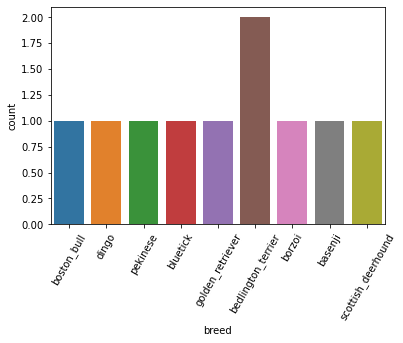

In [12]:
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns
sns.countplot(labels_dataframe['breed'][:10])
plt.xticks(rotation=60)
plt.show()

In [13]:
dog_breeds=sorted(list(set(labels_dataframe['breed'])))
n_classes=len(dog_breeds)
print(n_classes)
print(dog_breeds[:15])

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound']


In [14]:
classes_to_num=dict(zip(dog_breeds,range(n_classes)))

In [15]:
classes_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [16]:
(train_dir+'/'+labels_dataframe['id']+'.jpg')[0]

'C:/Users/mohan/Dogs/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [17]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[0]).shape

(375, 500, 3)

In [18]:
cv2.imread((train_dir+'/'+labels_dataframe['id']+'.jpg')[6]).shape

(470, 500, 3)

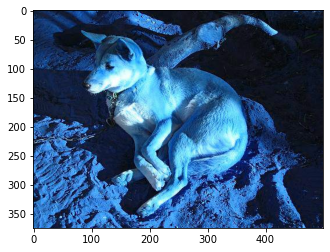

In [19]:
plt.imshow(cv2.imread((train_dir+'/'+labels_dataframe.id+'.jpg')[1]))

In [20]:
labels_dataframe['file_name']=labels_dataframe['id'].apply(lambda x: train_dir+'/'+f"{x}.jpg")
labels_dataframe

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,C:/Users/mohan/Dogs/train/000bec180eb18c7604dc...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,C:/Users/mohan/Dogs/train/001513dfcb2ffafc82cc...
2,001cdf01b096e06d78e9e5112d419397,pekinese,C:/Users/mohan/Dogs/train/001cdf01b096e06d78e9...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,C:/Users/mohan/Dogs/train/00214f311d5d2247d5df...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,C:/Users/mohan/Dogs/train/0021f9ceb3235effd7fc...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi,C:/Users/mohan/Dogs/train/ffd25009d635cfd16e79...
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont,C:/Users/mohan/Dogs/train/ffd3f636f7f379c51ba3...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale,C:/Users/mohan/Dogs/train/ffe2ca6c940cddfee68f...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher,C:/Users/mohan/Dogs/train/ffe5f6d8e2bff356e948...


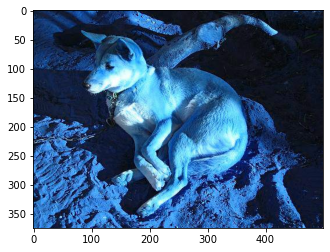

In [21]:
plt.imshow(cv2.imread(labels_dataframe['file_name'][1]))

In [22]:
labels_dataframe['breed']=labels_dataframe['breed'].map(classes_to_num)
labels_dataframe

,id,breed,file_name
0,000bec180eb18c7604dcecc8fe0dba07,19,C:/Users/mohan/Dogs/train/000bec180eb18c7604dc...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,C:/Users/mohan/Dogs/train/001513dfcb2ffafc82cc...
2,001cdf01b096e06d78e9e5112d419397,85,C:/Users/mohan/Dogs/train/001cdf01b096e06d78e9...
3,00214f311d5d2247d5dfe4fe24b2303d,15,C:/Users/mohan/Dogs/train/00214f311d5d2247d5df...
4,0021f9ceb3235effd7fcde7f7538ed62,49,C:/Users/mohan/Dogs/train/0021f9ceb3235effd7fc...
...,...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,18,C:/Users/mohan/Dogs/train/ffd25009d635cfd16e79...
10218,ffd3f636f7f379c51ba3648a9ff8254f,35,C:/Users/mohan/Dogs/train/ffd3f636f7f379c51ba3...
10219,ffe2ca6c940cddfee68fa3cc6c63213f,3,C:/Users/mohan/Dogs/train/ffe2ca6c940cddfee68f...
10220,ffe5f6d8e2bff356e9482a80a6e29aac,75,C:/Users/mohan/Dogs/train/ffe5f6d8e2bff356e948...


In [23]:
y=to_categorical(labels_dataframe['breed'])
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
y.shape

(10222, 120)

# Feature Extraction

In [25]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from keras.applications.xception import Xception , preprocess_input as xception_preprocess
from keras.applications.nasnet import NASNetLarge,preprocess_input as nasnet_preprocess
from keras.layers import concatenate

In [26]:
input_shape=(331,331,3)
input_layer=Input(shape=(input_shape))

In [27]:
input_layer

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'input_1')>

In [28]:
%time
preprocess_resnet=Lambda(resnet_preprocess)(input_layer)
inception_resnet=InceptionResNetV2(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocess_resnet)



preprocessor_inception=Lambda(inception_preprocess)(input_layer)
inception_v3=InceptionV3(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_inception)



preprocessor_xception=Lambda(xception_preprocess)(input_layer)
xception=Xception(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_xception)



preprocessor_nasnet=Lambda(nasnet_preprocess)(input_layer)
nasnet=NASNetLarge(weights='imagenet',include_top=False,
                                   input_shape=input_shape,pooling='avg')(preprocessor_nasnet)

Wall time: 0 ns


In [29]:
preprocess_resnet

<KerasTensor: shape=(None, 331, 331, 3) dtype=float32 (created by layer 'lambda')>

In [30]:
inception_resnet

<KerasTensor: shape=(None, 1536) dtype=float32 (created by layer 'inception_resnet_v2')>

In [31]:
%time
merge=concatenate([inception_resnet,inception_v3,xception,nasnet])
model=Model(inputs=input_layer,outputs=merge)

Wall time: 0 ns


In [32]:
merge

<KerasTensor: shape=(None, 9664) dtype=float32 (created by layer 'concatenate_6')>

In [33]:
model

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']            

In [35]:
model.input.shape

TensorShape([None, 331, 331, 3])

In [36]:
model.output.shape

TensorShape([None, 9664])

In [37]:
len(model.trainable_weights)

1846

# Feature extraction by using pretrained model

In [38]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 22
    x = np.zeros([data_size,9664], dtype=np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,x_col = 'file_name', class_mode = None, batch_size=batch_size, 
                                            shuffle = False,target_size = (img_size[:2]),color_mode = 'rgb')
    
    i = 0
    
    for input_batch in tqdm(generator):
        input_batch = model.predict(input_batch)
        x[i * batch_size : (i + 1) * batch_size] = input_batch
        i += 1
        if i * batch_size >= data_size:
            break
    return x
        

In [39]:
x=feature_extractor(labels_dataframe)

  0%|                                                                                          | 0/465 [00:00<?, ?it/s]

Found 10222 validated image filenames.
1/1 [==============================] - 49s 49s/step


  0%|▏                                                                               | 1/465 [00:49<6:25:38, 49.87s/it]

1/1 [==============================] - 23s 23s/step


  0%|▎                                                                               | 2/465 [01:12<4:23:24, 34.14s/it]

1/1 [==============================] - 22s 22s/step


  1%|▌                                                                               | 3/465 [01:35<3:43:01, 28.96s/it]

1/1 [==============================] - 22s 22s/step


  1%|▋                                                                               | 4/465 [01:58<3:23:54, 26.54s/it]

1/1 [==============================] - 26s 26s/step


  1%|▊                                                                               | 5/465 [02:24<3:22:11, 26.37s/it]

1/1 [==============================] - 24s 24s/step


  1%|█                                                                               | 6/465 [02:48<3:16:14, 25.65s/it]

1/1 [==============================] - 24s 24s/step


  2%|█▏                                                                              | 7/465 [03:12<3:11:46, 25.12s/it]

1/1 [==============================] - 24s 24s/step


  2%|█▍                                                                              | 8/465 [03:36<3:08:35, 24.76s/it]

1/1 [==============================] - 24s 24s/step


  2%|█▌                                                                              | 9/465 [04:00<3:06:24, 24.53s/it]

1/1 [==============================] - 23s 23s/step


  2%|█▋                                                                             | 10/465 [04:24<3:02:56, 24.12s/it]

1/1 [==============================] - 24s 24s/step


  2%|█▊                                                                             | 11/465 [04:48<3:02:02, 24.06s/it]

1/1 [==============================] - 23s 23s/step


  3%|██                                                                             | 12/465 [05:11<2:59:38, 23.79s/it]

1/1 [==============================] - 23s 23s/step


  3%|██▏                                                                            | 13/465 [05:34<2:57:37, 23.58s/it]

1/1 [==============================] - 25s 25s/step


  3%|██▍                                                                            | 14/465 [05:59<3:01:16, 24.12s/it]

1/1 [==============================] - 24s 24s/step


  3%|██▌                                                                            | 15/465 [06:24<3:01:33, 24.21s/it]

1/1 [==============================] - 24s 24s/step


  3%|██▋                                                                            | 16/465 [06:49<3:02:34, 24.40s/it]

1/1 [==============================] - 22s 22s/step


  4%|██▉                                                                            | 17/465 [07:11<2:57:38, 23.79s/it]

1/1 [==============================] - 23s 23s/step


  4%|███                                                                            | 18/465 [07:34<2:56:29, 23.69s/it]

1/1 [==============================] - 21s 21s/step


  4%|███▏                                                                           | 19/465 [07:56<2:51:38, 23.09s/it]

1/1 [==============================] - 17s 17s/step


  4%|███▍                                                                           | 20/465 [08:13<2:37:25, 21.23s/it]

1/1 [==============================] - 16s 16s/step


  5%|███▌                                                                           | 21/465 [08:29<2:25:16, 19.63s/it]

1/1 [==============================] - 16s 16s/step


  5%|███▋                                                                           | 22/465 [08:45<2:17:27, 18.62s/it]

1/1 [==============================] - 18s 18s/step


  5%|███▉                                                                           | 23/465 [09:03<2:15:36, 18.41s/it]

1/1 [==============================] - 20s 20s/step


  5%|████                                                                           | 24/465 [09:23<2:19:35, 18.99s/it]

1/1 [==============================] - 18s 18s/step


  5%|████▏                                                                          | 25/465 [09:41<2:16:53, 18.67s/it]

1/1 [==============================] - 17s 17s/step


  6%|████▍                                                                          | 26/465 [09:59<2:13:27, 18.24s/it]

1/1 [==============================] - 17s 17s/step


  6%|████▌                                                                          | 27/465 [10:16<2:11:17, 17.99s/it]

1/1 [==============================] - 18s 18s/step


  6%|████▊                                                                          | 28/465 [10:34<2:11:33, 18.06s/it]

1/1 [==============================] - 17s 17s/step


  6%|████▉                                                                          | 29/465 [10:51<2:08:59, 17.75s/it]

1/1 [==============================] - 19s 19s/step


  6%|█████                                                                          | 30/465 [11:10<2:12:07, 18.23s/it]

1/1 [==============================] - 17s 17s/step


  7%|█████▎                                                                         | 31/465 [11:27<2:08:55, 17.82s/it]

1/1 [==============================] - 16s 16s/step


  7%|█████▍                                                                         | 32/465 [11:44<2:05:42, 17.42s/it]

1/1 [==============================] - 17s 17s/step


  7%|█████▌                                                                         | 33/465 [12:01<2:04:08, 17.24s/it]

1/1 [==============================] - 16s 16s/step


  7%|█████▊                                                                         | 34/465 [12:17<2:02:08, 17.00s/it]

1/1 [==============================] - 16s 16s/step


  8%|█████▉                                                                         | 35/465 [12:33<1:58:56, 16.60s/it]

1/1 [==============================] - 16s 16s/step


  8%|██████                                                                         | 36/465 [12:49<1:56:56, 16.35s/it]

1/1 [==============================] - 16s 16s/step


  8%|██████▎                                                                        | 37/465 [13:05<1:56:55, 16.39s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▍                                                                        | 38/465 [13:20<1:54:34, 16.10s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▋                                                                        | 39/465 [13:36<1:52:48, 15.89s/it]

1/1 [==============================] - 15s 15s/step


  9%|██████▊                                                                        | 40/465 [13:51<1:50:41, 15.63s/it]

1/1 [==============================] - 16s 16s/step


  9%|██████▉                                                                        | 41/465 [14:07<1:52:18, 15.89s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████▏                                                                       | 42/465 [14:23<1:51:11, 15.77s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████▎                                                                       | 43/465 [14:38<1:50:07, 15.66s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████▍                                                                       | 44/465 [14:53<1:48:56, 15.53s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▋                                                                       | 45/465 [15:09<1:48:37, 15.52s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▊                                                                       | 46/465 [15:24<1:48:02, 15.47s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▉                                                                       | 47/465 [15:40<1:47:30, 15.43s/it]

1/1 [==============================] - 15s 15s/step


 10%|████████▏                                                                      | 48/465 [15:55<1:47:31, 15.47s/it]

1/1 [==============================] - 16s 16s/step


 11%|████████▎                                                                      | 49/465 [16:11<1:47:37, 15.52s/it]

1/1 [==============================] - 16s 16s/step


 11%|████████▍                                                                      | 50/465 [16:27<1:49:06, 15.78s/it]

1/1 [==============================] - 16s 16s/step


 11%|████████▋                                                                      | 51/465 [16:44<1:50:22, 16.00s/it]

1/1 [==============================] - 16s 16s/step


 11%|████████▊                                                                      | 52/465 [17:00<1:51:08, 16.15s/it]

1/1 [==============================] - 16s 16s/step


 11%|█████████                                                                      | 53/465 [17:16<1:51:02, 16.17s/it]

1/1 [==============================] - 16s 16s/step


 12%|█████████▏                                                                     | 54/465 [17:32<1:49:52, 16.04s/it]

1/1 [==============================] - 17s 17s/step


 12%|█████████▎                                                                     | 55/465 [17:49<1:51:52, 16.37s/it]

1/1 [==============================] - 18s 18s/step


 12%|█████████▌                                                                     | 56/465 [18:08<1:55:19, 16.92s/it]

1/1 [==============================] - 16s 16s/step


 12%|█████████▋                                                                     | 57/465 [18:23<1:52:41, 16.57s/it]

1/1 [==============================] - 21s 21s/step


 12%|█████████▊                                                                     | 58/465 [18:44<2:01:09, 17.86s/it]

1/1 [==============================] - 26s 26s/step


 13%|██████████                                                                     | 59/465 [19:11<2:18:30, 20.47s/it]

1/1 [==============================] - 26s 26s/step


 13%|██████████▏                                                                    | 60/465 [19:37<2:30:34, 22.31s/it]

1/1 [==============================] - 26s 26s/step


 13%|██████████▎                                                                    | 61/465 [20:04<2:39:06, 23.63s/it]

1/1 [==============================] - 25s 25s/step


 13%|██████████▌                                                                    | 62/465 [20:30<2:42:45, 24.23s/it]

1/1 [==============================] - 25s 25s/step


 14%|██████████▋                                                                    | 63/465 [20:56<2:45:43, 24.74s/it]

1/1 [==============================] - 26s 26s/step


 14%|██████████▊                                                                    | 64/465 [21:22<2:48:19, 25.19s/it]

1/1 [==============================] - 21s 21s/step


 14%|███████████                                                                    | 65/465 [21:43<2:39:24, 23.91s/it]

1/1 [==============================] - 17s 17s/step


 14%|███████████▏                                                                   | 66/465 [22:00<2:24:58, 21.80s/it]

1/1 [==============================] - 17s 17s/step


 14%|███████████▍                                                                   | 67/465 [22:17<2:15:03, 20.36s/it]

1/1 [==============================] - 17s 17s/step


 15%|███████████▌                                                                   | 68/465 [22:34<2:08:51, 19.48s/it]

1/1 [==============================] - 15s 15s/step


 15%|███████████▋                                                                   | 69/465 [22:50<2:01:04, 18.34s/it]

1/1 [==============================] - 16s 16s/step


 15%|███████████▉                                                                   | 70/465 [23:06<1:56:07, 17.64s/it]

1/1 [==============================] - 17s 17s/step


 15%|████████████                                                                   | 71/465 [23:23<1:55:27, 17.58s/it]

1/1 [==============================] - 16s 16s/step


 15%|████████████▏                                                                  | 72/465 [23:39<1:51:45, 17.06s/it]

1/1 [==============================] - 15s 15s/step


 16%|████████████▍                                                                  | 73/465 [23:55<1:48:26, 16.60s/it]

1/1 [==============================] - 15s 15s/step


 16%|████████████▌                                                                  | 74/465 [24:10<1:45:42, 16.22s/it]

1/1 [==============================] - 15s 15s/step


 16%|████████████▋                                                                  | 75/465 [24:26<1:44:13, 16.03s/it]

1/1 [==============================] - 15s 15s/step


 16%|████████████▉                                                                  | 76/465 [24:41<1:42:18, 15.78s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████                                                                  | 77/465 [24:56<1:41:47, 15.74s/it]

1/1 [==============================] - 16s 16s/step


 17%|█████████████▎                                                                 | 78/465 [25:12<1:41:26, 15.73s/it]

1/1 [==============================] - 16s 16s/step


 17%|█████████████▍                                                                 | 79/465 [25:28<1:41:53, 15.84s/it]

1/1 [==============================] - 20s 20s/step


 17%|█████████████▌                                                                 | 80/465 [25:48<1:50:12, 17.17s/it]

1/1 [==============================] - 26s 26s/step


 17%|█████████████▊                                                                 | 81/465 [26:15<2:08:48, 20.13s/it]

1/1 [==============================] - 26s 26s/step


 18%|█████████████▉                                                                 | 82/465 [26:42<2:21:04, 22.10s/it]

1/1 [==============================] - 31s 31s/step


 18%|██████████████                                                                 | 83/465 [27:13<2:38:01, 24.82s/it]

1/1 [==============================] - 28s 28s/step


 18%|██████████████▎                                                                | 84/465 [27:42<2:45:06, 26.00s/it]

1/1 [==============================] - 29s 29s/step


 18%|██████████████▍                                                                | 85/465 [28:15<2:57:46, 28.07s/it]

1/1 [==============================] - 28s 28s/step


 18%|██████████████▌                                                                | 86/465 [28:43<2:57:41, 28.13s/it]

1/1 [==============================] - 27s 27s/step


 19%|██████████████▊                                                                | 87/465 [29:11<2:55:44, 27.90s/it]

1/1 [==============================] - 22s 22s/step


 19%|██████████████▉                                                                | 88/465 [29:33<2:44:50, 26.23s/it]

1/1 [==============================] - 27s 27s/step


 19%|███████████████                                                                | 89/465 [30:00<2:46:41, 26.60s/it]

1/1 [==============================] - 29s 29s/step


 19%|███████████████▎                                                               | 90/465 [30:30<2:51:28, 27.44s/it]

1/1 [==============================] - 30s 30s/step


 20%|███████████████▍                                                               | 91/465 [31:12<3:18:09, 31.79s/it]

1/1 [==============================] - 31s 31s/step


 20%|███████████████▋                                                               | 92/465 [31:43<3:16:29, 31.61s/it]

1/1 [==============================] - 29s 29s/step


 20%|███████████████▊                                                               | 93/465 [32:12<3:11:17, 30.85s/it]

1/1 [==============================] - 30s 30s/step


 20%|███████████████▉                                                               | 94/465 [32:43<3:10:35, 30.82s/it]

1/1 [==============================] - 34s 34s/step


 20%|████████████████▏                                                              | 95/465 [33:17<3:17:14, 31.98s/it]

1/1 [==============================] - 29s 29s/step


 21%|████████████████▎                                                              | 96/465 [33:47<3:12:11, 31.25s/it]

1/1 [==============================] - 29s 29s/step


 21%|████████████████▍                                                              | 97/465 [34:17<3:08:53, 30.80s/it]

1/1 [==============================] - 26s 26s/step


 21%|████████████████▋                                                              | 98/465 [34:43<2:59:42, 29.38s/it]

1/1 [==============================] - 26s 26s/step


 21%|████████████████▊                                                              | 99/465 [35:09<2:53:40, 28.47s/it]

1/1 [==============================] - 25s 25s/step


 22%|████████████████▊                                                             | 100/465 [35:35<2:48:29, 27.70s/it]

1/1 [==============================] - 26s 26s/step


 22%|████████████████▉                                                             | 101/465 [36:02<2:46:25, 27.43s/it]

1/1 [==============================] - 29s 29s/step


 22%|█████████████████                                                             | 102/465 [36:31<2:49:19, 27.99s/it]

1/1 [==============================] - 30s 30s/step


 22%|█████████████████▎                                                            | 103/465 [37:02<2:54:06, 28.86s/it]

1/1 [==============================] - 28s 28s/step


 22%|█████████████████▍                                                            | 104/465 [37:31<2:53:18, 28.80s/it]

1/1 [==============================] - 28s 28s/step


 23%|█████████████████▌                                                            | 105/465 [37:59<2:52:39, 28.78s/it]

1/1 [==============================] - 26s 26s/step


 23%|█████████████████▊                                                            | 106/465 [38:26<2:48:14, 28.12s/it]

1/1 [==============================] - 27s 27s/step


 23%|█████████████████▉                                                            | 107/465 [38:54<2:47:17, 28.04s/it]

1/1 [==============================] - 25s 25s/step


 23%|██████████████████                                                            | 108/465 [39:20<2:42:43, 27.35s/it]

1/1 [==============================] - 25s 25s/step


 23%|██████████████████▎                                                           | 109/465 [39:45<2:39:12, 26.83s/it]

1/1 [==============================] - 25s 25s/step


 24%|██████████████████▍                                                           | 110/465 [40:11<2:37:00, 26.54s/it]

1/1 [==============================] - 25s 25s/step


 24%|██████████████████▌                                                           | 111/465 [40:37<2:34:54, 26.26s/it]

1/1 [==============================] - 18s 18s/step


 24%|██████████████████▊                                                           | 112/465 [40:55<2:21:11, 24.00s/it]

1/1 [==============================] - 18s 18s/step


 24%|██████████████████▉                                                           | 113/465 [41:14<2:11:14, 22.37s/it]

1/1 [==============================] - 18s 18s/step


 25%|███████████████████                                                           | 114/465 [41:32<2:03:08, 21.05s/it]

1/1 [==============================] - 15s 15s/step


 25%|███████████████████▎                                                          | 115/465 [41:47<1:52:53, 19.35s/it]

1/1 [==============================] - 17s 17s/step


 25%|███████████████████▍                                                          | 116/465 [42:04<1:48:16, 18.62s/it]

1/1 [==============================] - 17s 17s/step


 25%|███████████████████▋                                                          | 117/465 [42:21<1:44:50, 18.07s/it]

1/1 [==============================] - 16s 16s/step


 25%|███████████████████▊                                                          | 118/465 [42:37<1:40:58, 17.46s/it]

1/1 [==============================] - 16s 16s/step


 26%|███████████████████▉                                                          | 119/465 [42:53<1:37:52, 16.97s/it]

1/1 [==============================] - 16s 16s/step


 26%|████████████████████▏                                                         | 120/465 [43:09<1:35:50, 16.67s/it]

1/1 [==============================] - 15s 15s/step


 26%|████████████████████▎                                                         | 121/465 [43:24<1:33:41, 16.34s/it]

1/1 [==============================] - 15s 15s/step


 26%|████████████████████▍                                                         | 122/465 [43:40<1:32:09, 16.12s/it]

1/1 [==============================] - 15s 15s/step


 26%|████████████████████▋                                                         | 123/465 [43:56<1:31:01, 15.97s/it]

1/1 [==============================] - 16s 16s/step


 27%|████████████████████▊                                                         | 124/465 [44:12<1:30:53, 15.99s/it]

1/1 [==============================] - 16s 16s/step


 27%|████████████████████▉                                                         | 125/465 [44:28<1:30:50, 16.03s/it]

1/1 [==============================] - 17s 17s/step


 27%|█████████████████████▏                                                        | 126/465 [44:45<1:32:48, 16.43s/it]

1/1 [==============================] - 18s 18s/step


 27%|█████████████████████▎                                                        | 127/465 [45:03<1:34:42, 16.81s/it]

1/1 [==============================] - 17s 17s/step


 28%|█████████████████████▍                                                        | 128/465 [45:21<1:35:51, 17.07s/it]

1/1 [==============================] - 16s 16s/step


 28%|█████████████████████▋                                                        | 129/465 [45:37<1:34:40, 16.91s/it]

1/1 [==============================] - 16s 16s/step


 28%|█████████████████████▊                                                        | 130/465 [45:54<1:33:31, 16.75s/it]

1/1 [==============================] - 16s 16s/step


 28%|█████████████████████▉                                                        | 131/465 [46:10<1:32:13, 16.57s/it]

1/1 [==============================] - 26s 26s/step


 28%|██████████████████████▏                                                       | 132/465 [46:36<1:47:30, 19.37s/it]

1/1 [==============================] - 29s 29s/step


 29%|██████████████████████▎                                                       | 133/465 [47:05<2:04:02, 22.42s/it]

1/1 [==============================] - 25s 25s/step


 29%|██████████████████████▍                                                       | 134/465 [47:31<2:08:58, 23.38s/it]

1/1 [==============================] - 19s 19s/step


 29%|██████████████████████▋                                                       | 135/465 [47:49<2:00:56, 21.99s/it]

1/1 [==============================] - 19s 19s/step


 29%|██████████████████████▊                                                       | 136/465 [48:08<1:55:30, 21.06s/it]

1/1 [==============================] - 16s 16s/step


 29%|██████████████████████▉                                                       | 137/465 [48:25<1:47:06, 19.59s/it]

1/1 [==============================] - 16s 16s/step


 30%|███████████████████████▏                                                      | 138/465 [48:40<1:40:31, 18.44s/it]

1/1 [==============================] - 16s 16s/step


 30%|███████████████████████▎                                                      | 139/465 [48:56<1:36:19, 17.73s/it]

1/1 [==============================] - 18s 18s/step


 30%|███████████████████████▍                                                      | 140/465 [49:14<1:36:15, 17.77s/it]

1/1 [==============================] - 17s 17s/step


 30%|███████████████████████▋                                                      | 141/465 [49:31<1:35:08, 17.62s/it]

1/1 [==============================] - 16s 16s/step


 31%|███████████████████████▊                                                      | 142/465 [49:48<1:32:22, 17.16s/it]

1/1 [==============================] - 16s 16s/step


 31%|███████████████████████▉                                                      | 143/465 [50:04<1:31:01, 16.96s/it]

1/1 [==============================] - 15s 15s/step


 31%|████████████████████████▏                                                     | 144/465 [50:19<1:27:45, 16.40s/it]

1/1 [==============================] - 16s 16s/step


 31%|████████████████████████▎                                                     | 145/465 [50:35<1:27:15, 16.36s/it]

1/1 [==============================] - 16s 16s/step


 31%|████████████████████████▍                                                     | 146/465 [50:51<1:26:12, 16.21s/it]

1/1 [==============================] - 17s 17s/step


 32%|████████████████████████▋                                                     | 147/465 [51:08<1:26:46, 16.37s/it]

1/1 [==============================] - 17s 17s/step


 32%|████████████████████████▊                                                     | 148/465 [51:25<1:27:13, 16.51s/it]

1/1 [==============================] - 17s 17s/step


 32%|████████████████████████▉                                                     | 149/465 [51:42<1:27:16, 16.57s/it]

1/1 [==============================] - 17s 17s/step


 32%|█████████████████████████▏                                                    | 150/465 [51:59<1:27:44, 16.71s/it]

1/1 [==============================] - 16s 16s/step


 32%|█████████████████████████▎                                                    | 151/465 [52:15<1:26:52, 16.60s/it]

1/1 [==============================] - 18s 18s/step


 33%|█████████████████████████▍                                                    | 152/465 [52:33<1:28:19, 16.93s/it]

1/1 [==============================] - 17s 17s/step


 33%|█████████████████████████▋                                                    | 153/465 [52:50<1:28:19, 16.99s/it]

1/1 [==============================] - 16s 16s/step


 33%|█████████████████████████▊                                                    | 154/465 [53:06<1:26:17, 16.65s/it]

1/1 [==============================] - 16s 16s/step


 33%|██████████████████████████                                                    | 155/465 [53:22<1:25:45, 16.60s/it]

1/1 [==============================] - 16s 16s/step


 34%|██████████████████████████▏                                                   | 156/465 [53:38<1:24:24, 16.39s/it]

1/1 [==============================] - 18s 18s/step


 34%|██████████████████████████▎                                                   | 157/465 [53:56<1:27:09, 16.98s/it]

1/1 [==============================] - 18s 18s/step


 34%|██████████████████████████▌                                                   | 158/465 [54:14<1:28:37, 17.32s/it]

1/1 [==============================] - 17s 17s/step


 34%|██████████████████████████▋                                                   | 159/465 [54:32<1:28:23, 17.33s/it]

1/1 [==============================] - 16s 16s/step


 34%|██████████████████████████▊                                                   | 160/465 [54:48<1:26:56, 17.10s/it]

1/1 [==============================] - 16s 16s/step


 35%|███████████████████████████                                                   | 161/465 [55:05<1:25:11, 16.82s/it]

1/1 [==============================] - 17s 17s/step


 35%|███████████████████████████▏                                                  | 162/465 [55:22<1:25:22, 16.90s/it]

1/1 [==============================] - 15s 15s/step


 35%|███████████████████████████▎                                                  | 163/465 [55:37<1:22:56, 16.48s/it]

1/1 [==============================] - 16s 16s/step


 35%|███████████████████████████▌                                                  | 164/465 [55:53<1:21:48, 16.31s/it]

1/1 [==============================] - 16s 16s/step


 35%|███████████████████████████▋                                                  | 165/465 [56:10<1:21:44, 16.35s/it]

1/1 [==============================] - 16s 16s/step


 36%|███████████████████████████▊                                                  | 166/465 [56:26<1:21:19, 16.32s/it]

1/1 [==============================] - 24s 24s/step


 36%|████████████████████████████                                                  | 167/465 [56:50<1:32:56, 18.71s/it]

1/1 [==============================] - 29s 29s/step


 36%|████████████████████████████▏                                                 | 168/465 [57:20<1:49:02, 22.03s/it]

1/1 [==============================] - 30s 30s/step


 36%|████████████████████████████▎                                                 | 169/465 [57:51<2:01:44, 24.68s/it]

1/1 [==============================] - 28s 28s/step


 37%|████████████████████████████▌                                                 | 170/465 [58:19<2:06:35, 25.75s/it]

1/1 [==============================] - 26s 26s/step


 37%|████████████████████████████▋                                                 | 171/465 [58:46<2:08:09, 26.15s/it]

1/1 [==============================] - 27s 27s/step


 37%|████████████████████████████▊                                                 | 172/465 [59:13<2:08:55, 26.40s/it]

1/1 [==============================] - 17s 17s/step


 37%|█████████████████████████████                                                 | 173/465 [59:30<1:54:48, 23.59s/it]

1/1 [==============================] - 16s 16s/step


 37%|█████████████████████████████▏                                                | 174/465 [59:47<1:44:12, 21.49s/it]

1/1 [==============================] - 17s 17s/step


 38%|████████████████████████████▌                                               | 175/465 [1:00:04<1:37:44, 20.22s/it]

1/1 [==============================] - 17s 17s/step


 38%|████████████████████████████▊                                               | 176/465 [1:00:21<1:32:40, 19.24s/it]

1/1 [==============================] - 17s 17s/step


 38%|████████████████████████████▉                                               | 177/465 [1:00:38<1:28:54, 18.52s/it]

1/1 [==============================] - 17s 17s/step


 38%|█████████████████████████████                                               | 178/465 [1:00:55<1:26:10, 18.02s/it]

1/1 [==============================] - 17s 17s/step


 38%|█████████████████████████████▎                                              | 179/465 [1:01:12<1:25:17, 17.89s/it]

1/1 [==============================] - 16s 16s/step


 39%|█████████████████████████████▍                                              | 180/465 [1:01:29<1:22:54, 17.45s/it]

1/1 [==============================] - 20s 20s/step


 39%|█████████████████████████████▌                                              | 181/465 [1:01:48<1:25:57, 18.16s/it]

1/1 [==============================] - 18s 18s/step


 39%|█████████████████████████████▋                                              | 182/465 [1:02:06<1:25:13, 18.07s/it]

1/1 [==============================] - 19s 19s/step


 39%|█████████████████████████████▉                                              | 183/465 [1:02:26<1:26:43, 18.45s/it]

1/1 [==============================] - 17s 17s/step


 40%|██████████████████████████████                                              | 184/465 [1:02:43<1:24:54, 18.13s/it]

1/1 [==============================] - 17s 17s/step


 40%|██████████████████████████████▏                                             | 185/465 [1:03:00<1:22:57, 17.78s/it]

1/1 [==============================] - 16s 16s/step


 40%|██████████████████████████████▍                                             | 186/465 [1:03:17<1:21:07, 17.45s/it]

1/1 [==============================] - 16s 16s/step


 40%|██████████████████████████████▌                                             | 187/465 [1:03:33<1:19:32, 17.17s/it]

1/1 [==============================] - 16s 16s/step


 40%|██████████████████████████████▋                                             | 188/465 [1:03:49<1:17:41, 16.83s/it]

1/1 [==============================] - 16s 16s/step


 41%|██████████████████████████████▉                                             | 189/465 [1:04:06<1:17:09, 16.77s/it]

1/1 [==============================] - 17s 17s/step


 41%|███████████████████████████████                                             | 190/465 [1:04:23<1:17:57, 17.01s/it]

1/1 [==============================] - 18s 18s/step


 41%|███████████████████████████████▏                                            | 191/465 [1:04:41<1:18:55, 17.28s/it]

1/1 [==============================] - 16s 16s/step


 41%|███████████████████████████████▍                                            | 192/465 [1:04:57<1:16:42, 16.86s/it]

1/1 [==============================] - 16s 16s/step


 42%|███████████████████████████████▌                                            | 193/465 [1:05:13<1:15:29, 16.65s/it]

1/1 [==============================] - 15s 15s/step


 42%|███████████████████████████████▋                                            | 194/465 [1:05:29<1:13:21, 16.24s/it]

1/1 [==============================] - 15s 15s/step


 42%|███████████████████████████████▊                                            | 195/465 [1:05:44<1:12:08, 16.03s/it]

1/1 [==============================] - 17s 17s/step


 42%|████████████████████████████████                                            | 196/465 [1:06:01<1:12:50, 16.25s/it]

1/1 [==============================] - 17s 17s/step


 42%|████████████████████████████████▏                                           | 197/465 [1:06:18<1:13:48, 16.52s/it]

1/1 [==============================] - 17s 17s/step


 43%|████████████████████████████████▎                                           | 198/465 [1:06:35<1:13:58, 16.62s/it]

1/1 [==============================] - 17s 17s/step


 43%|████████████████████████████████▌                                           | 199/465 [1:06:52<1:14:28, 16.80s/it]

1/1 [==============================] - 17s 17s/step


 43%|████████████████████████████████▋                                           | 200/465 [1:07:10<1:15:19, 17.05s/it]

1/1 [==============================] - 18s 18s/step


 43%|████████████████████████████████▊                                           | 201/465 [1:07:28<1:16:56, 17.49s/it]

1/1 [==============================] - 16s 16s/step


 43%|█████████████████████████████████                                           | 202/465 [1:07:45<1:15:19, 17.18s/it]

1/1 [==============================] - 17s 17s/step


 44%|█████████████████████████████████▏                                          | 203/465 [1:08:02<1:14:59, 17.17s/it]

1/1 [==============================] - 16s 16s/step


 44%|█████████████████████████████████▎                                          | 204/465 [1:08:18<1:13:23, 16.87s/it]

1/1 [==============================] - 17s 17s/step


 44%|█████████████████████████████████▌                                          | 205/465 [1:08:35<1:12:56, 16.83s/it]

1/1 [==============================] - 15s 15s/step


 44%|█████████████████████████████████▋                                          | 206/465 [1:08:50<1:10:45, 16.39s/it]

1/1 [==============================] - 18s 18s/step


 45%|█████████████████████████████████▊                                          | 207/465 [1:09:08<1:12:47, 16.93s/it]

1/1 [==============================] - 15s 15s/step


 45%|█████████████████████████████████▉                                          | 208/465 [1:09:24<1:10:50, 16.54s/it]

1/1 [==============================] - 17s 17s/step


 45%|██████████████████████████████████▏                                         | 209/465 [1:09:41<1:11:40, 16.80s/it]

1/1 [==============================] - 16s 16s/step


 45%|██████████████████████████████████▎                                         | 210/465 [1:09:58<1:10:40, 16.63s/it]

1/1 [==============================] - 16s 16s/step


 45%|██████████████████████████████████▍                                         | 211/465 [1:10:14<1:10:28, 16.65s/it]

1/1 [==============================] - 16s 16s/step


 46%|██████████████████████████████████▋                                         | 212/465 [1:10:31<1:09:59, 16.60s/it]

1/1 [==============================] - 15s 15s/step


 46%|██████████████████████████████████▊                                         | 213/465 [1:10:46<1:07:58, 16.18s/it]

1/1 [==============================] - 16s 16s/step


 46%|██████████████████████████████████▉                                         | 214/465 [1:11:02<1:08:00, 16.26s/it]

1/1 [==============================] - 16s 16s/step


 46%|███████████████████████████████████▏                                        | 215/465 [1:11:19<1:07:38, 16.24s/it]

1/1 [==============================] - 15s 15s/step


 46%|███████████████████████████████████▎                                        | 216/465 [1:11:34<1:06:35, 16.05s/it]

1/1 [==============================] - 16s 16s/step


 47%|███████████████████████████████████▍                                        | 217/465 [1:11:51<1:06:48, 16.16s/it]

1/1 [==============================] - 16s 16s/step


 47%|███████████████████████████████████▋                                        | 218/465 [1:12:07<1:06:25, 16.14s/it]

1/1 [==============================] - 16s 16s/step


 47%|███████████████████████████████████▊                                        | 219/465 [1:12:22<1:05:35, 16.00s/it]

1/1 [==============================] - 16s 16s/step


 47%|███████████████████████████████████▉                                        | 220/465 [1:12:38<1:05:21, 16.01s/it]

1/1 [==============================] - 17s 17s/step


 48%|████████████████████████████████████                                        | 221/465 [1:12:56<1:07:01, 16.48s/it]

1/1 [==============================] - 17s 17s/step


 48%|████████████████████████████████████▎                                       | 222/465 [1:13:13<1:07:38, 16.70s/it]

1/1 [==============================] - 16s 16s/step


 48%|████████████████████████████████████▍                                       | 223/465 [1:13:30<1:07:04, 16.63s/it]

1/1 [==============================] - 17s 17s/step


 48%|████████████████████████████████████▌                                       | 224/465 [1:13:46<1:06:49, 16.64s/it]

1/1 [==============================] - 17s 17s/step


 48%|████████████████████████████████████▊                                       | 225/465 [1:14:03<1:06:36, 16.65s/it]

1/1 [==============================] - 16s 16s/step


 49%|████████████████████████████████████▉                                       | 226/465 [1:14:19<1:05:26, 16.43s/it]

1/1 [==============================] - 16s 16s/step


 49%|█████████████████████████████████████                                       | 227/465 [1:14:35<1:04:33, 16.28s/it]

1/1 [==============================] - 16s 16s/step


 49%|█████████████████████████████████████▎                                      | 228/465 [1:14:51<1:03:55, 16.18s/it]

1/1 [==============================] - 17s 17s/step


 49%|█████████████████████████████████████▍                                      | 229/465 [1:15:08<1:04:20, 16.36s/it]

1/1 [==============================] - 16s 16s/step


 49%|█████████████████████████████████████▌                                      | 230/465 [1:15:24<1:03:47, 16.29s/it]

1/1 [==============================] - 16s 16s/step


 50%|█████████████████████████████████████▊                                      | 231/465 [1:15:40<1:04:01, 16.42s/it]

1/1 [==============================] - 17s 17s/step


 50%|█████████████████████████████████████▉                                      | 232/465 [1:15:57<1:04:22, 16.58s/it]

1/1 [==============================] - 18s 18s/step


 50%|██████████████████████████████████████                                      | 233/465 [1:16:16<1:06:19, 17.15s/it]

1/1 [==============================] - 16s 16s/step


 50%|██████████████████████████████████████▏                                     | 234/465 [1:16:32<1:04:31, 16.76s/it]

1/1 [==============================] - 17s 17s/step


 51%|██████████████████████████████████████▍                                     | 235/465 [1:16:49<1:04:34, 16.84s/it]

1/1 [==============================] - 16s 16s/step


 51%|██████████████████████████████████████▌                                     | 236/465 [1:17:06<1:04:12, 16.82s/it]

1/1 [==============================] - 15s 15s/step


 51%|██████████████████████████████████████▋                                     | 237/465 [1:17:21<1:02:09, 16.36s/it]

1/1 [==============================] - 15s 15s/step


 51%|██████████████████████████████████████▉                                     | 238/465 [1:17:36<1:00:25, 15.97s/it]

1/1 [==============================] - 15s 15s/step


 51%|████████████████████████████████████████                                      | 239/465 [1:17:51<59:00, 15.66s/it]

1/1 [==============================] - 15s 15s/step


 52%|████████████████████████████████████████▎                                     | 240/465 [1:18:06<58:23, 15.57s/it]

1/1 [==============================] - 15s 15s/step


 52%|████████████████████████████████████████▍                                     | 241/465 [1:18:21<57:36, 15.43s/it]

1/1 [==============================] - 15s 15s/step


 52%|████████████████████████████████████████▌                                     | 242/465 [1:18:36<56:46, 15.27s/it]

1/1 [==============================] - 15s 15s/step


 52%|████████████████████████████████████████▊                                     | 243/465 [1:18:51<56:10, 15.18s/it]

1/1 [==============================] - 15s 15s/step


 52%|████████████████████████████████████████▉                                     | 244/465 [1:19:07<56:08, 15.24s/it]

1/1 [==============================] - 15s 15s/step


 53%|█████████████████████████████████████████                                     | 245/465 [1:19:22<55:45, 15.21s/it]

1/1 [==============================] - 15s 15s/step


 53%|█████████████████████████████████████████▎                                    | 246/465 [1:19:37<55:21, 15.17s/it]

1/1 [==============================] - 15s 15s/step


 53%|█████████████████████████████████████████▍                                    | 247/465 [1:19:52<55:02, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 53%|█████████████████████████████████████████▌                                    | 248/465 [1:20:07<55:14, 15.27s/it]

1/1 [==============================] - 15s 15s/step


 54%|█████████████████████████████████████████▊                                    | 249/465 [1:20:22<54:45, 15.21s/it]

1/1 [==============================] - 15s 15s/step


 54%|█████████████████████████████████████████▉                                    | 250/465 [1:20:37<54:12, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 54%|██████████████████████████████████████████                                    | 251/465 [1:20:52<53:53, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 54%|██████████████████████████████████████████▎                                   | 252/465 [1:21:08<54:03, 15.23s/it]

1/1 [==============================] - 15s 15s/step


 54%|██████████████████████████████████████████▍                                   | 253/465 [1:21:23<53:47, 15.22s/it]

1/1 [==============================] - 15s 15s/step


 55%|██████████████████████████████████████████▌                                   | 254/465 [1:21:39<53:58, 15.35s/it]

1/1 [==============================] - 15s 15s/step


 55%|██████████████████████████████████████████▊                                   | 255/465 [1:21:54<53:27, 15.27s/it]

1/1 [==============================] - 15s 15s/step


 55%|██████████████████████████████████████████▉                                   | 256/465 [1:22:09<53:29, 15.35s/it]

1/1 [==============================] - 15s 15s/step


 55%|███████████████████████████████████████████                                   | 257/465 [1:22:25<53:01, 15.30s/it]

1/1 [==============================] - 15s 15s/step


 55%|███████████████████████████████████████████▎                                  | 258/465 [1:22:40<52:30, 15.22s/it]

1/1 [==============================] - 15s 15s/step


 56%|███████████████████████████████████████████▍                                  | 259/465 [1:22:55<51:58, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 56%|███████████████████████████████████████████▌                                  | 260/465 [1:23:10<52:00, 15.22s/it]

1/1 [==============================] - 15s 15s/step


 56%|███████████████████████████████████████████▊                                  | 261/465 [1:23:25<51:29, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 56%|███████████████████████████████████████████▉                                  | 262/465 [1:23:40<51:10, 15.12s/it]

1/1 [==============================] - 15s 15s/step


 57%|████████████████████████████████████████████                                  | 263/465 [1:23:55<50:48, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 57%|████████████████████████████████████████████▎                                 | 264/465 [1:24:10<50:41, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 57%|████████████████████████████████████████████▍                                 | 265/465 [1:24:25<50:28, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 57%|████████████████████████████████████████████▌                                 | 266/465 [1:24:41<50:33, 15.25s/it]

1/1 [==============================] - 16s 16s/step


 57%|████████████████████████████████████████████▊                                 | 267/465 [1:24:57<51:08, 15.50s/it]

1/1 [==============================] - 15s 15s/step


 58%|████████████████████████████████████████████▉                                 | 268/465 [1:25:13<50:54, 15.51s/it]

1/1 [==============================] - 15s 15s/step


 58%|█████████████████████████████████████████████                                 | 269/465 [1:25:28<50:08, 15.35s/it]

1/1 [==============================] - 15s 15s/step


 58%|█████████████████████████████████████████████▎                                | 270/465 [1:25:43<49:32, 15.24s/it]

1/1 [==============================] - 15s 15s/step


 58%|█████████████████████████████████████████████▍                                | 271/465 [1:25:58<49:01, 15.16s/it]

1/1 [==============================] - 15s 15s/step


 58%|█████████████████████████████████████████████▋                                | 272/465 [1:26:13<48:54, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 59%|█████████████████████████████████████████████▊                                | 273/465 [1:26:28<48:28, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 59%|█████████████████████████████████████████████▉                                | 274/465 [1:26:43<48:01, 15.08s/it]

1/1 [==============================] - 15s 15s/step


 59%|██████████████████████████████████████████████▏                               | 275/465 [1:26:58<47:56, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 59%|██████████████████████████████████████████████▎                               | 276/465 [1:27:13<47:43, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 60%|██████████████████████████████████████████████▍                               | 277/465 [1:27:28<47:17, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 60%|██████████████████████████████████████████████▋                               | 278/465 [1:27:43<46:54, 15.05s/it]

1/1 [==============================] - 15s 15s/step


 60%|██████████████████████████████████████████████▊                               | 279/465 [1:27:58<46:54, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 60%|██████████████████████████████████████████████▉                               | 280/465 [1:28:13<46:26, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 60%|███████████████████████████████████████████████▏                              | 281/465 [1:28:28<46:03, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 61%|███████████████████████████████████████████████▎                              | 282/465 [1:28:43<45:37, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 61%|███████████████████████████████████████████████▍                              | 283/465 [1:28:58<45:42, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 61%|███████████████████████████████████████████████▋                              | 284/465 [1:29:13<45:19, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 61%|███████████████████████████████████████████████▊                              | 285/465 [1:29:28<45:00, 15.00s/it]

1/1 [==============================] - 15s 15s/step


 62%|███████████████████████████████████████████████▉                              | 286/465 [1:29:43<44:37, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▏                             | 287/465 [1:29:59<44:48, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▎                             | 288/465 [1:30:14<44:27, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▍                             | 289/465 [1:30:28<44:02, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▋                             | 290/465 [1:30:43<43:43, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 63%|████████████████████████████████████████████████▊                             | 291/465 [1:30:59<43:44, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 63%|████████████████████████████████████████████████▉                             | 292/465 [1:31:14<43:17, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████▏                            | 293/465 [1:31:29<42:57, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████▎                            | 294/465 [1:31:43<42:35, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████▍                            | 295/465 [1:31:59<42:42, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 64%|█████████████████████████████████████████████████▋                            | 296/465 [1:32:14<42:19, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 64%|█████████████████████████████████████████████████▊                            | 297/465 [1:32:29<42:03, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 64%|█████████████████████████████████████████████████▉                            | 298/465 [1:32:44<41:39, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 64%|██████████████████████████████████████████████████▏                           | 299/465 [1:32:59<41:46, 15.10s/it]

1/1 [==============================] - 16s 16s/step


 65%|██████████████████████████████████████████████████▎                           | 300/465 [1:33:15<42:09, 15.33s/it]

1/1 [==============================] - 15s 15s/step


 65%|██████████████████████████████████████████████████▍                           | 301/465 [1:33:30<41:41, 15.25s/it]

1/1 [==============================] - 15s 15s/step


 65%|██████████████████████████████████████████████████▋                           | 302/465 [1:33:45<41:10, 15.16s/it]

1/1 [==============================] - 15s 15s/step


 65%|██████████████████████████████████████████████████▊                           | 303/465 [1:34:00<41:05, 15.22s/it]

1/1 [==============================] - 15s 15s/step


 65%|██████████████████████████████████████████████████▉                           | 304/465 [1:34:15<40:30, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 66%|███████████████████████████████████████████████████▏                          | 305/465 [1:34:30<40:16, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 66%|███████████████████████████████████████████████████▎                          | 306/465 [1:34:45<39:58, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 66%|███████████████████████████████████████████████████▍                          | 307/465 [1:35:00<39:46, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 66%|███████████████████████████████████████████████████▋                          | 308/465 [1:35:15<39:20, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 66%|███████████████████████████████████████████████████▊                          | 309/465 [1:35:30<38:57, 14.98s/it]

1/1 [==============================] - 16s 16s/step


 67%|████████████████████████████████████████████████████                          | 310/465 [1:35:46<39:15, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 67%|████████████████████████████████████████████████████▏                         | 311/465 [1:36:01<38:45, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 67%|████████████████████████████████████████████████████▎                         | 312/465 [1:36:15<38:17, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 67%|████████████████████████████████████████████████████▌                         | 313/465 [1:36:30<37:52, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 68%|████████████████████████████████████████████████████▋                         | 314/465 [1:36:46<37:55, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 68%|████████████████████████████████████████████████████▊                         | 315/465 [1:37:01<37:50, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 68%|█████████████████████████████████████████████████████                         | 316/465 [1:37:16<37:25, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 68%|█████████████████████████████████████████████████████▏                        | 317/465 [1:37:31<37:09, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 68%|█████████████████████████████████████████████████████▎                        | 318/465 [1:37:46<36:46, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 69%|█████████████████████████████████████████████████████▌                        | 319/465 [1:38:01<36:46, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 69%|█████████████████████████████████████████████████████▋                        | 320/465 [1:38:16<36:19, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 69%|█████████████████████████████████████████████████████▊                        | 321/465 [1:38:31<35:53, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 69%|██████████████████████████████████████████████████████                        | 322/465 [1:38:45<35:31, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 69%|██████████████████████████████████████████████████████▏                       | 323/465 [1:39:01<35:37, 15.05s/it]

1/1 [==============================] - 15s 15s/step


 70%|██████████████████████████████████████████████████████▎                       | 324/465 [1:39:16<35:13, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 70%|██████████████████████████████████████████████████████▌                       | 325/465 [1:39:31<34:55, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 70%|██████████████████████████████████████████████████████▋                       | 326/465 [1:39:45<34:34, 14.93s/it]

1/1 [==============================] - 16s 16s/step


 70%|██████████████████████████████████████████████████████▊                       | 327/465 [1:40:02<35:15, 15.33s/it]

1/1 [==============================] - 15s 15s/step


 71%|███████████████████████████████████████████████████████                       | 328/465 [1:40:17<35:10, 15.40s/it]

1/1 [==============================] - 16s 16s/step


 71%|███████████████████████████████████████████████████████▏                      | 329/465 [1:40:33<35:11, 15.53s/it]

1/1 [==============================] - 15s 15s/step


 71%|███████████████████████████████████████████████████████▎                      | 330/465 [1:40:48<34:50, 15.49s/it]

1/1 [==============================] - 16s 16s/step


 71%|███████████████████████████████████████████████████████▌                      | 331/465 [1:41:04<34:48, 15.58s/it]

1/1 [==============================] - 15s 15s/step


 71%|███████████████████████████████████████████████████████▋                      | 332/465 [1:41:19<34:03, 15.37s/it]

1/1 [==============================] - 15s 15s/step


 72%|███████████████████████████████████████████████████████▊                      | 333/465 [1:41:34<33:29, 15.22s/it]

1/1 [==============================] - 15s 15s/step


 72%|████████████████████████████████████████████████████████                      | 334/465 [1:41:49<33:02, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 72%|████████████████████████████████████████████████████████▏                     | 335/465 [1:42:04<32:51, 15.16s/it]

1/1 [==============================] - 15s 15s/step


 72%|████████████████████████████████████████████████████████▎                     | 336/465 [1:42:19<32:24, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 72%|████████████████████████████████████████████████████████▌                     | 337/465 [1:42:34<32:03, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 73%|████████████████████████████████████████████████████████▋                     | 338/465 [1:42:49<31:43, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 73%|████████████████████████████████████████████████████████▊                     | 339/465 [1:43:04<31:37, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 73%|█████████████████████████████████████████████████████████                     | 340/465 [1:43:19<31:17, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 73%|█████████████████████████████████████████████████████████▏                    | 341/465 [1:43:34<30:52, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▎                    | 342/465 [1:43:49<30:31, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▌                    | 343/465 [1:44:04<30:28, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▋                    | 344/465 [1:44:19<30:09, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▊                    | 345/465 [1:44:34<29:55, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 74%|██████████████████████████████████████████████████████████                    | 346/465 [1:44:49<29:45, 15.00s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▏                   | 347/465 [1:45:04<29:47, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▎                   | 348/465 [1:45:19<29:31, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▌                   | 349/465 [1:45:34<29:14, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▋                   | 350/465 [1:45:49<28:51, 15.05s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▉                   | 351/465 [1:46:05<28:44, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 76%|███████████████████████████████████████████████████████████                   | 352/465 [1:46:19<28:21, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 76%|███████████████████████████████████████████████████████████▏                  | 353/465 [1:46:34<28:01, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 76%|███████████████████████████████████████████████████████████▍                  | 354/465 [1:46:49<27:42, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 76%|███████████████████████████████████████████████████████████▌                  | 355/465 [1:47:05<27:36, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 77%|███████████████████████████████████████████████████████████▋                  | 356/465 [1:47:19<27:16, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 77%|███████████████████████████████████████████████████████████▉                  | 357/465 [1:47:34<26:59, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 77%|████████████████████████████████████████████████████████████                  | 358/465 [1:47:49<26:38, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 77%|████████████████████████████████████████████████████████████▏                 | 359/465 [1:48:05<26:36, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 77%|████████████████████████████████████████████████████████████▍                 | 360/465 [1:48:19<26:13, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 78%|████████████████████████████████████████████████████████████▌                 | 361/465 [1:48:34<25:54, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 78%|████████████████████████████████████████████████████████████▋                 | 362/465 [1:48:49<25:40, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 78%|████████████████████████████████████████████████████████████▉                 | 363/465 [1:49:04<25:34, 15.04s/it]

1/1 [==============================] - 15s 15s/step


 78%|█████████████████████████████████████████████████████████████                 | 364/465 [1:49:19<25:13, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 78%|█████████████████████████████████████████████████████████████▏                | 365/465 [1:49:34<24:57, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 79%|█████████████████████████████████████████████████████████████▍                | 366/465 [1:49:49<24:41, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 79%|█████████████████████████████████████████████████████████████▌                | 367/465 [1:50:05<24:42, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 79%|█████████████████████████████████████████████████████████████▋                | 368/465 [1:50:20<24:24, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 79%|█████████████████████████████████████████████████████████████▉                | 369/465 [1:50:35<24:00, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 80%|██████████████████████████████████████████████████████████████                | 370/465 [1:50:50<23:45, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 80%|██████████████████████████████████████████████████████████████▏               | 371/465 [1:51:05<23:36, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 80%|██████████████████████████████████████████████████████████████▍               | 372/465 [1:51:20<23:15, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 80%|██████████████████████████████████████████████████████████████▌               | 373/465 [1:51:34<22:55, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 80%|██████████████████████████████████████████████████████████████▋               | 374/465 [1:51:49<22:37, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 81%|██████████████████████████████████████████████████████████████▉               | 375/465 [1:52:05<22:34, 15.05s/it]

1/1 [==============================] - 15s 15s/step


 81%|███████████████████████████████████████████████████████████████               | 376/465 [1:52:19<22:14, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 81%|███████████████████████████████████████████████████████████████▏              | 377/465 [1:52:34<21:57, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 81%|███████████████████████████████████████████████████████████████▍              | 378/465 [1:52:50<21:47, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 82%|███████████████████████████████████████████████████████████████▌              | 379/465 [1:53:05<21:39, 15.12s/it]

1/1 [==============================] - 15s 15s/step


 82%|███████████████████████████████████████████████████████████████▋              | 380/465 [1:53:20<21:16, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 82%|███████████████████████████████████████████████████████████████▉              | 381/465 [1:53:35<20:57, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 82%|████████████████████████████████████████████████████████████████              | 382/465 [1:53:49<20:37, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 82%|████████████████████████████████████████████████████████████████▏             | 383/465 [1:54:05<20:30, 15.00s/it]

1/1 [==============================] - 15s 15s/step


 83%|████████████████████████████████████████████████████████████████▍             | 384/465 [1:54:19<20:14, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 83%|████████████████████████████████████████████████████████████████▌             | 385/465 [1:54:34<19:58, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 83%|████████████████████████████████████████████████████████████████▋             | 386/465 [1:54:49<19:41, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 83%|████████████████████████████████████████████████████████████████▉             | 387/465 [1:55:04<19:29, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 83%|█████████████████████████████████████████████████████████████████             | 388/465 [1:55:19<19:13, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 84%|█████████████████████████████████████████████████████████████████▎            | 389/465 [1:55:34<18:55, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 84%|█████████████████████████████████████████████████████████████████▍            | 390/465 [1:55:49<18:37, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 84%|█████████████████████████████████████████████████████████████████▌            | 391/465 [1:56:04<18:26, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 84%|█████████████████████████████████████████████████████████████████▊            | 392/465 [1:56:19<18:08, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 85%|█████████████████████████████████████████████████████████████████▉            | 393/465 [1:56:34<17:52, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 85%|██████████████████████████████████████████████████████████████████            | 394/465 [1:56:49<17:38, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 395/465 [1:57:04<17:23, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 85%|██████████████████████████████████████████████████████████████████▍           | 396/465 [1:57:19<17:10, 14.93s/it]

1/1 [==============================] - 15s 15s/step


 85%|██████████████████████████████████████████████████████████████████▌           | 397/465 [1:57:33<16:52, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 86%|██████████████████████████████████████████████████████████████████▊           | 398/465 [1:57:48<16:37, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 86%|██████████████████████████████████████████████████████████████████▉           | 399/465 [1:58:03<16:22, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 86%|███████████████████████████████████████████████████████████████████           | 400/465 [1:58:18<16:08, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 86%|███████████████████████████████████████████████████████████████████▎          | 401/465 [1:58:33<15:50, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 86%|███████████████████████████████████████████████████████████████████▍          | 402/465 [1:58:48<15:35, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 403/465 [1:59:02<15:17, 14.80s/it]

1/1 [==============================] - 15s 15s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 404/465 [1:59:17<15:03, 14.81s/it]

1/1 [==============================] - 15s 15s/step


 87%|███████████████████████████████████████████████████████████████████▉          | 405/465 [1:59:32<14:49, 14.83s/it]

1/1 [==============================] - 15s 15s/step


 87%|████████████████████████████████████████████████████████████████████          | 406/465 [1:59:47<14:35, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 88%|████████████████████████████████████████████████████████████████████▎         | 407/465 [2:00:02<14:20, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 88%|████████████████████████████████████████████████████████████████████▍         | 408/465 [2:00:17<14:04, 14.82s/it]

1/1 [==============================] - 15s 15s/step


 88%|████████████████████████████████████████████████████████████████████▌         | 409/465 [2:00:31<13:49, 14.81s/it]

1/1 [==============================] - 15s 15s/step


 88%|████████████████████████████████████████████████████████████████████▊         | 410/465 [2:00:46<13:35, 14.82s/it]

1/1 [==============================] - 15s 15s/step


 88%|████████████████████████████████████████████████████████████████████▉         | 411/465 [2:01:01<13:21, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 89%|█████████████████████████████████████████████████████████████████████         | 412/465 [2:01:16<13:07, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 413/465 [2:01:31<12:50, 14.83s/it]

1/1 [==============================] - 15s 15s/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 414/465 [2:01:46<12:37, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 415/465 [2:02:00<12:22, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 416/465 [2:02:15<12:07, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 417/465 [2:02:30<11:52, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 90%|██████████████████████████████████████████████████████████████████████        | 418/465 [2:02:45<11:37, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 419/465 [2:03:00<11:24, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 420/465 [2:03:15<11:09, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 421/465 [2:03:30<10:52, 14.83s/it]

1/1 [==============================] - 15s 15s/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 422/465 [2:03:44<10:38, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 423/465 [2:03:59<10:26, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 91%|███████████████████████████████████████████████████████████████████████       | 424/465 [2:04:14<10:10, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 425/465 [2:04:30<09:59, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 426/465 [2:04:44<09:42, 14.93s/it]

1/1 [==============================] - 15s 15s/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 427/465 [2:04:59<09:26, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 428/465 [2:05:14<09:11, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 429/465 [2:05:29<08:55, 14.87s/it]

1/1 [==============================] - 15s 15s/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 430/465 [2:05:44<08:40, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 431/465 [2:05:59<08:25, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 432/465 [2:06:14<08:12, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 433/465 [2:06:28<07:55, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 434/465 [2:06:43<07:41, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 435/465 [2:06:58<07:25, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 436/465 [2:07:13<07:11, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 437/465 [2:07:28<06:56, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 438/465 [2:07:43<06:40, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 439/465 [2:07:58<06:27, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 440/465 [2:08:13<06:14, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 441/465 [2:08:28<05:59, 14.96s/it]

1/1 [==============================] - 15s 15s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 442/465 [2:08:43<05:43, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 443/465 [2:08:58<05:28, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 444/465 [2:09:12<05:12, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 445/465 [2:09:27<04:58, 14.93s/it]

1/1 [==============================] - 15s 15s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 446/465 [2:09:43<04:44, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 447/465 [2:09:57<04:29, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 448/465 [2:10:12<04:14, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 449/465 [2:10:27<03:58, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 450/465 [2:10:42<03:43, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 451/465 [2:10:57<03:28, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 452/465 [2:11:12<03:14, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 453/465 [2:11:27<02:58, 14.91s/it]

1/1 [==============================] - 15s 15s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 454/465 [2:11:42<02:43, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 455/465 [2:11:57<02:28, 14.88s/it]

1/1 [==============================] - 15s 15s/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 456/465 [2:12:11<02:13, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 457/465 [2:12:26<01:58, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 458/465 [2:12:41<01:43, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 459/465 [2:12:56<01:29, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 460/465 [2:13:11<01:14, 14.83s/it]

1/1 [==============================] - 15s 15s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 461/465 [2:13:26<00:59, 14.83s/it]

1/1 [==============================] - 15s 15s/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 462/465 [2:13:40<00:44, 14.84s/it]

1/1 [==============================] - 15s 15s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 463/465 [2:13:55<00:29, 14.84s/it]

1/1 [==============================] - 15s 15s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 464/465 [2:14:10<00:14, 14.80s/it]

1/1 [==============================] - 10s 10s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 464/465 [2:14:20<00:17, 17.37s/it]


In [40]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [41]:
x.shape

(10222, 9664)

In [42]:
x[0].shape

(9664,)

In [43]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
earlystop=EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)
checkpoint=ModelCheckpoint('kaggle/working/checkpoint',monitor='val_loss',mode='min',save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=1e-6)
my_callback=[earlystop,checkpoint,lr]

# Let's create the model

In [44]:
x.shape[1:]

(9664,)

In [47]:
%time
nn=keras.models.Sequential([
    
    InputLayer(x.shape[1:]),
    Dropout(0.7),
    Dense(n_classes,activation='softmax')
    
    
])

nn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
h=nn.fit(x,y,batch_size=120,epochs=100,validation_split=0.20,callbacks=my_callback)

Wall time: 0 ns
Epoch 1/100
69/69 [==============================] - 2s 21ms/step - loss: 3.9862 - accuracy: 0.5379 - val_loss: 2.9577 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 1s 20ms/step - loss: 2.2157 - accuracy: 0.9024 - val_loss: 1.7125 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 1s 20ms/step - loss: 1.3648 - accuracy: 0.9292 - val_loss: 1.1695 - val_accuracy: 0.9198 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - 1s 20ms/step - loss: 0.9650 - accuracy: 0.9435 - val_loss: 0.9005 - val_accuracy: 0.9208 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.7614 - accuracy: 0.9464 - val_loss: 0.7457 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 6/100
69/69 [==============================] - 2s 26ms/step - loss: 0.6307 - accuracy: 0.9523 - val_loss: 0.6456 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 7/100
69/69 [==============================] - 2

69/69 [==============================] - 1s 22ms/step - loss: 0.0789 - accuracy: 0.9886 - val_loss: 0.2871 - val_accuracy: 0.9237 - lr: 6.2500e-05
Epoch 65/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0771 - accuracy: 0.9887 - val_loss: 0.2871 - val_accuracy: 0.9237 - lr: 6.2500e-05
Epoch 66/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0819 - accuracy: 0.9883 - val_loss: 0.2871 - val_accuracy: 0.9237 - lr: 3.1250e-05
Epoch 67/100
69/69 [==============================] - 1s 20ms/step - loss: 0.0783 - accuracy: 0.9869 - val_loss: 0.2872 - val_accuracy: 0.9237 - lr: 3.1250e-05
Epoch 68/100
69/69 [==============================] - 1s 20ms/step - loss: 0.0769 - accuracy: 0.9891 - val_loss: 0.2872 - val_accuracy: 0.9232 - lr: 3.1250e-05
Epoch 69/100
69/69 [==============================] - 1s 19ms/step - loss: 0.0783 - accuracy: 0.9874 - val_loss: 0.2872 - val_accuracy: 0.9232 - lr: 1.5625e-05
Epoch 70/100
69/69 [==============================] -

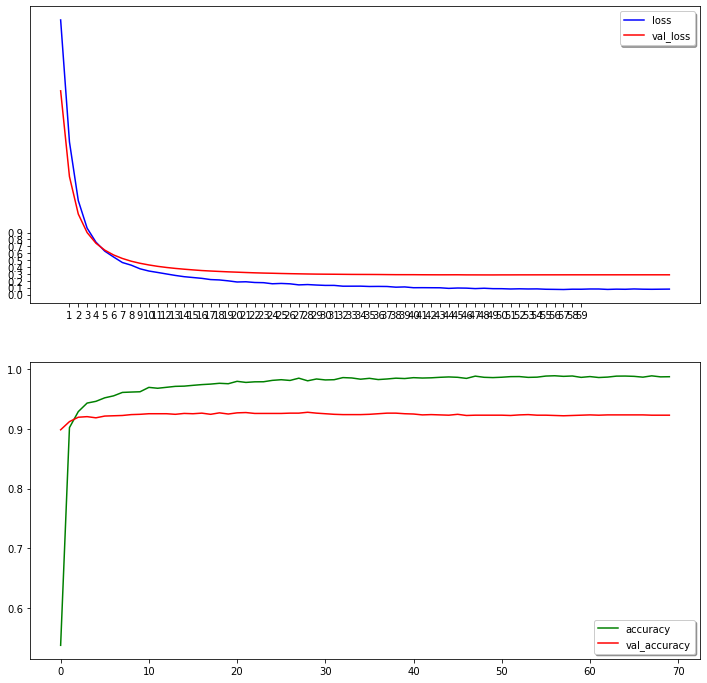

In [48]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(h.history['loss'],color = 'b',label = 'loss')
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1, 60, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(['loss','val_loss'],shadow = True)


ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

In [49]:
test_data=[]
ids=[]

for pic in os.listdir(test_dir):
    ids.append(pic.split('.')[0])
    test_data.append(test_dir+'/'+pic)

In [50]:
ids[0]

'000621fb3cbb32d8935728e48679680e'

In [51]:
test_data[0]

'C:/Users/mohan/Dogs/test/000621fb3cbb32d8935728e48679680e.jpg'

In [52]:
test_dataframe=pd.DataFrame({'file_name':test_data})
test_dataframe

,file_name
0,C:/Users/mohan/Dogs/test/000621fb3cbb32d893572...
1,C:/Users/mohan/Dogs/test/00102ee9d8eb908123506...
2,C:/Users/mohan/Dogs/test/0012a730dfa437f5f3613...
3,C:/Users/mohan/Dogs/test/001510bc8570bbeee98c8...
4,C:/Users/mohan/Dogs/test/001a5f3114548acdefa3d...
...,...
10352,C:/Users/mohan/Dogs/test/ffeda8623d4eee33c6d11...
10353,C:/Users/mohan/Dogs/test/fff1ec9e6e41327598496...
10354,C:/Users/mohan/Dogs/test/fff74b59b758bbbf13a57...
10355,C:/Users/mohan/Dogs/test/fff7d50d848e8014ac1e9...


In [53]:
test_features=feature_extractor(test_dataframe)

  0%|                                                                                          | 0/471 [00:00<?, ?it/s]

Found 10357 validated image filenames.
1/1 [==============================] - 15s 15s/step


  0%|▏                                                                               | 1/471 [00:14<1:55:30, 14.75s/it]

1/1 [==============================] - 18s 18s/step


  0%|▎                                                                               | 2/471 [00:32<2:09:27, 16.56s/it]

1/1 [==============================] - 16s 16s/step


  1%|▌                                                                               | 3/471 [00:48<2:08:01, 16.41s/it]

1/1 [==============================] - 18s 18s/step


  1%|▋                                                                               | 4/471 [01:06<2:11:53, 16.95s/it]

1/1 [==============================] - 16s 16s/step


  1%|▊                                                                               | 5/471 [01:22<2:08:51, 16.59s/it]

1/1 [==============================] - 17s 17s/step


  1%|█                                                                               | 6/471 [01:39<2:08:59, 16.64s/it]

1/1 [==============================] - 17s 17s/step


  1%|█▏                                                                              | 7/471 [01:56<2:09:02, 16.69s/it]

1/1 [==============================] - 16s 16s/step


  2%|█▎                                                                              | 8/471 [02:12<2:07:01, 16.46s/it]

1/1 [==============================] - 16s 16s/step


  2%|█▌                                                                              | 9/471 [02:28<2:06:11, 16.39s/it]

1/1 [==============================] - 16s 16s/step


  2%|█▋                                                                             | 10/471 [02:44<2:05:49, 16.38s/it]

1/1 [==============================] - 15s 15s/step


  2%|█▊                                                                             | 11/471 [02:59<2:01:58, 15.91s/it]

1/1 [==============================] - 15s 15s/step


  3%|██                                                                             | 12/471 [03:14<1:58:59, 15.56s/it]

1/1 [==============================] - 15s 15s/step


  3%|██▏                                                                            | 13/471 [03:28<1:56:44, 15.29s/it]

1/1 [==============================] - 15s 15s/step


  3%|██▎                                                                            | 14/471 [03:44<1:56:17, 15.27s/it]

1/1 [==============================] - 15s 15s/step


  3%|██▌                                                                            | 15/471 [03:58<1:54:57, 15.13s/it]

1/1 [==============================] - 15s 15s/step


  3%|██▋                                                                            | 16/471 [04:13<1:54:36, 15.11s/it]

1/1 [==============================] - 15s 15s/step


  4%|██▊                                                                            | 17/471 [04:29<1:54:13, 15.10s/it]

1/1 [==============================] - 15s 15s/step


  4%|███                                                                            | 18/471 [04:44<1:54:35, 15.18s/it]

1/1 [==============================] - 15s 15s/step


  4%|███▏                                                                           | 19/471 [04:59<1:53:41, 15.09s/it]

1/1 [==============================] - 15s 15s/step


  4%|███▎                                                                           | 20/471 [05:14<1:52:52, 15.02s/it]

1/1 [==============================] - 16s 16s/step


  4%|███▌                                                                           | 21/471 [05:30<1:56:00, 15.47s/it]

1/1 [==============================] - 16s 16s/step


  5%|███▋                                                                           | 22/471 [05:46<1:56:42, 15.60s/it]

1/1 [==============================] - 15s 15s/step


  5%|███▊                                                                           | 23/471 [06:02<1:56:22, 15.59s/it]

1/1 [==============================] - 15s 15s/step


  5%|████                                                                           | 24/471 [06:17<1:55:42, 15.53s/it]

1/1 [==============================] - 15s 15s/step


  5%|████▏                                                                          | 25/471 [06:33<1:55:45, 15.57s/it]

1/1 [==============================] - 15s 15s/step


  6%|████▎                                                                          | 26/471 [06:48<1:55:19, 15.55s/it]

1/1 [==============================] - 15s 15s/step


  6%|████▌                                                                          | 27/471 [07:03<1:53:50, 15.38s/it]

1/1 [==============================] - 15s 15s/step


  6%|████▋                                                                          | 28/471 [07:18<1:53:09, 15.33s/it]

1/1 [==============================] - 16s 16s/step


  6%|████▊                                                                          | 29/471 [07:34<1:53:39, 15.43s/it]

1/1 [==============================] - 15s 15s/step


  6%|█████                                                                          | 30/471 [07:49<1:52:25, 15.30s/it]

1/1 [==============================] - 15s 15s/step


  7%|█████▏                                                                         | 31/471 [08:04<1:51:12, 15.17s/it]

1/1 [==============================] - 15s 15s/step


  7%|█████▎                                                                         | 32/471 [08:19<1:50:12, 15.06s/it]

1/1 [==============================] - 15s 15s/step


  7%|█████▌                                                                         | 33/471 [08:34<1:50:26, 15.13s/it]

1/1 [==============================] - 15s 15s/step


  7%|█████▋                                                                         | 34/471 [08:49<1:49:34, 15.05s/it]

1/1 [==============================] - 15s 15s/step


  7%|█████▊                                                                         | 35/471 [09:04<1:49:12, 15.03s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████                                                                         | 36/471 [09:19<1:48:55, 15.03s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▏                                                                        | 37/471 [09:34<1:49:19, 15.11s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▎                                                                        | 38/471 [09:49<1:48:30, 15.04s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▌                                                                        | 39/471 [10:04<1:47:52, 14.98s/it]

1/1 [==============================] - 15s 15s/step


  8%|██████▋                                                                        | 40/471 [10:19<1:47:31, 14.97s/it]

1/1 [==============================] - 15s 15s/step


  9%|██████▉                                                                        | 41/471 [10:34<1:47:57, 15.06s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████                                                                        | 42/471 [10:49<1:47:07, 14.98s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████▏                                                                       | 43/471 [11:04<1:47:01, 15.00s/it]

1/1 [==============================] - 15s 15s/step


  9%|███████▍                                                                       | 44/471 [11:19<1:46:33, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▌                                                                       | 45/471 [11:34<1:47:31, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▋                                                                       | 46/471 [11:49<1:46:59, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 10%|███████▉                                                                       | 47/471 [12:04<1:46:22, 15.05s/it]

1/1 [==============================] - 15s 15s/step


 10%|████████                                                                       | 48/471 [12:19<1:45:40, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 10%|████████▏                                                                      | 49/471 [12:34<1:46:00, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 11%|████████▍                                                                      | 50/471 [12:49<1:45:38, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 11%|████████▌                                                                      | 51/471 [13:04<1:44:51, 14.98s/it]

1/1 [==============================] - 15s 15s/step


 11%|████████▋                                                                      | 52/471 [13:19<1:44:10, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 11%|████████▉                                                                      | 53/471 [13:34<1:43:44, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 11%|█████████                                                                      | 54/471 [13:49<1:43:22, 14.87s/it]

1/1 [==============================] - 15s 15s/step


 12%|█████████▏                                                                     | 55/471 [14:04<1:43:18, 14.90s/it]

1/1 [==============================] - 15s 15s/step


 12%|█████████▍                                                                     | 56/471 [14:18<1:42:45, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 12%|█████████▌                                                                     | 57/471 [14:33<1:42:35, 14.87s/it]

1/1 [==============================] - 15s 15s/step


 12%|█████████▋                                                                     | 58/471 [14:49<1:43:12, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 13%|█████████▉                                                                     | 59/471 [15:04<1:43:02, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 13%|██████████                                                                     | 60/471 [15:18<1:42:26, 14.95s/it]

1/1 [==============================] - 15s 15s/step


 13%|██████████▏                                                                    | 61/471 [15:33<1:41:58, 14.92s/it]

1/1 [==============================] - 15s 15s/step


 13%|██████████▍                                                                    | 62/471 [15:48<1:41:31, 14.89s/it]

1/1 [==============================] - 15s 15s/step


 13%|██████████▌                                                                    | 63/471 [16:03<1:42:07, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 14%|██████████▋                                                                    | 64/471 [16:18<1:41:21, 14.94s/it]

1/1 [==============================] - 15s 15s/step


 14%|██████████▉                                                                    | 65/471 [16:33<1:40:34, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 14%|███████████                                                                    | 66/471 [16:48<1:40:22, 14.87s/it]

1/1 [==============================] - 15s 15s/step


 14%|███████████▏                                                                   | 67/471 [17:03<1:40:03, 14.86s/it]

1/1 [==============================] - 15s 15s/step


 14%|███████████▍                                                                   | 68/471 [17:17<1:39:45, 14.85s/it]

1/1 [==============================] - 15s 15s/step


 15%|███████████▌                                                                   | 69/471 [17:32<1:39:13, 14.81s/it]

1/1 [==============================] - 15s 15s/step


 15%|███████████▋                                                                   | 70/471 [17:47<1:39:04, 14.82s/it]

1/1 [==============================] - 15s 15s/step


 15%|███████████▉                                                                   | 71/471 [18:02<1:38:56, 14.84s/it]

1/1 [==============================] - 15s 15s/step


 15%|████████████                                                                   | 72/471 [18:17<1:38:31, 14.81s/it]

1/1 [==============================] - 18s 18s/step


 15%|████████████▏                                                                  | 73/471 [18:35<1:45:23, 15.89s/it]

1/1 [==============================] - 16s 16s/step


 16%|████████████▍                                                                  | 74/471 [18:52<1:46:19, 16.07s/it]

1/1 [==============================] - 16s 16s/step


 16%|████████████▌                                                                  | 75/471 [19:08<1:46:54, 16.20s/it]

1/1 [==============================] - 16s 16s/step


 16%|████████████▋                                                                  | 76/471 [19:24<1:46:15, 16.14s/it]

1/1 [==============================] - 15s 15s/step


 16%|████████████▉                                                                  | 77/471 [19:40<1:44:50, 15.97s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████                                                                  | 78/471 [19:55<1:42:45, 15.69s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████▎                                                                 | 79/471 [20:10<1:41:05, 15.47s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████▍                                                                 | 80/471 [20:25<1:39:51, 15.32s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████▌                                                                 | 81/471 [20:40<1:39:39, 15.33s/it]

1/1 [==============================] - 15s 15s/step


 17%|█████████████▊                                                                 | 82/471 [20:55<1:38:44, 15.23s/it]

1/1 [==============================] - 15s 15s/step


 18%|█████████████▉                                                                 | 83/471 [21:10<1:37:49, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 18%|██████████████                                                                 | 84/471 [21:25<1:37:53, 15.18s/it]

1/1 [==============================] - 16s 16s/step


 18%|██████████████▎                                                                | 85/471 [21:41<1:39:08, 15.41s/it]

1/1 [==============================] - 16s 16s/step


 18%|██████████████▍                                                                | 86/471 [21:57<1:40:26, 15.65s/it]

1/1 [==============================] - 15s 15s/step


 18%|██████████████▌                                                                | 87/471 [22:13<1:39:57, 15.62s/it]

1/1 [==============================] - 16s 16s/step


 19%|██████████████▊                                                                | 88/471 [22:29<1:41:05, 15.84s/it]

1/1 [==============================] - 18s 18s/step


 19%|██████████████▉                                                                | 89/471 [22:47<1:45:19, 16.54s/it]

1/1 [==============================] - 21s 21s/step


 19%|███████████████                                                                | 90/471 [23:09<1:54:09, 17.98s/it]

1/1 [==============================] - 19s 19s/step


 19%|███████████████▎                                                               | 91/471 [23:28<1:56:24, 18.38s/it]

1/1 [==============================] - 20s 20s/step


 20%|███████████████▍                                                               | 92/471 [23:48<1:58:42, 18.79s/it]

1/1 [==============================] - 17s 17s/step


 20%|███████████████▌                                                               | 93/471 [24:05<1:55:12, 18.29s/it]

1/1 [==============================] - 16s 16s/step


 20%|███████████████▊                                                               | 94/471 [24:22<1:51:46, 17.79s/it]

1/1 [==============================] - 18s 18s/step


 20%|███████████████▉                                                               | 95/471 [24:39<1:51:46, 17.84s/it]

1/1 [==============================] - 16s 16s/step


 20%|████████████████                                                               | 96/471 [24:56<1:48:36, 17.38s/it]

1/1 [==============================] - 16s 16s/step


 21%|████████████████▎                                                              | 97/471 [25:12<1:45:47, 16.97s/it]

1/1 [==============================] - 15s 15s/step


 21%|████████████████▍                                                              | 98/471 [25:27<1:42:52, 16.55s/it]

1/1 [==============================] - 19s 19s/step


 21%|████████████████▌                                                              | 99/471 [25:46<1:47:00, 17.26s/it]

1/1 [==============================] - 19s 19s/step


 21%|████████████████▌                                                             | 100/471 [26:05<1:49:26, 17.70s/it]

1/1 [==============================] - 18s 18s/step


 21%|████████████████▋                                                             | 101/471 [26:24<1:51:02, 18.01s/it]

1/1 [==============================] - 21s 21s/step


 22%|████████████████▉                                                             | 102/471 [26:45<1:57:22, 19.09s/it]

1/1 [==============================] - 17s 17s/step


 22%|█████████████████                                                             | 103/471 [27:02<1:52:52, 18.40s/it]

1/1 [==============================] - 16s 16s/step


 22%|█████████████████▏                                                            | 104/471 [27:19<1:48:59, 17.82s/it]

1/1 [==============================] - 16s 16s/step


 22%|█████████████████▍                                                            | 105/471 [27:35<1:46:08, 17.40s/it]

1/1 [==============================] - 18s 18s/step


 23%|█████████████████▌                                                            | 106/471 [27:53<1:46:35, 17.52s/it]

1/1 [==============================] - 17s 17s/step


 23%|█████████████████▋                                                            | 107/471 [28:10<1:45:42, 17.43s/it]

1/1 [==============================] - 17s 17s/step


 23%|█████████████████▉                                                            | 108/471 [28:28<1:45:35, 17.45s/it]

1/1 [==============================] - 16s 16s/step


 23%|██████████████████                                                            | 109/471 [28:44<1:43:34, 17.17s/it]

1/1 [==============================] - 18s 18s/step


 23%|██████████████████▏                                                           | 110/471 [29:02<1:44:54, 17.43s/it]

1/1 [==============================] - 17s 17s/step


 24%|██████████████████▍                                                           | 111/471 [29:19<1:43:43, 17.29s/it]

1/1 [==============================] - 16s 16s/step


 24%|██████████████████▌                                                           | 112/471 [29:35<1:41:55, 17.03s/it]

1/1 [==============================] - 15s 15s/step


 24%|██████████████████▋                                                           | 113/471 [29:51<1:39:06, 16.61s/it]

1/1 [==============================] - 15s 15s/step


 24%|██████████████████▉                                                           | 114/471 [30:06<1:36:28, 16.21s/it]

1/1 [==============================] - 17s 17s/step


 24%|███████████████████                                                           | 115/471 [30:24<1:38:25, 16.59s/it]

1/1 [==============================] - 19s 19s/step


 25%|███████████████████▏                                                          | 116/471 [30:43<1:41:51, 17.22s/it]

1/1 [==============================] - 17s 17s/step


 25%|███████████████████▍                                                          | 117/471 [31:00<1:41:26, 17.19s/it]

1/1 [==============================] - 15s 15s/step


 25%|███████████████████▌                                                          | 118/471 [31:15<1:38:04, 16.67s/it]

1/1 [==============================] - 15s 15s/step


 25%|███████████████████▋                                                          | 119/471 [31:30<1:34:48, 16.16s/it]

1/1 [==============================] - 15s 15s/step


 25%|███████████████████▊                                                          | 120/471 [31:45<1:33:03, 15.91s/it]

1/1 [==============================] - 15s 15s/step


 26%|████████████████████                                                          | 121/471 [32:01<1:31:22, 15.66s/it]

1/1 [==============================] - 16s 16s/step


 26%|████████████████████▏                                                         | 122/471 [32:16<1:31:10, 15.68s/it]

1/1 [==============================] - 15s 15s/step


 26%|████████████████████▎                                                         | 123/471 [32:32<1:30:20, 15.58s/it]

1/1 [==============================] - 16s 16s/step


 26%|████████████████████▌                                                         | 124/471 [32:48<1:31:01, 15.74s/it]

1/1 [==============================] - 15s 15s/step


 27%|████████████████████▋                                                         | 125/471 [33:03<1:30:00, 15.61s/it]

1/1 [==============================] - 17s 17s/step


 27%|████████████████████▊                                                         | 126/471 [33:20<1:32:15, 16.05s/it]

1/1 [==============================] - 18s 18s/step


 27%|█████████████████████                                                         | 127/471 [33:38<1:35:23, 16.64s/it]

1/1 [==============================] - 17s 17s/step


 27%|█████████████████████▏                                                        | 128/471 [33:55<1:35:29, 16.70s/it]

1/1 [==============================] - 17s 17s/step


 27%|█████████████████████▎                                                        | 129/471 [34:12<1:35:34, 16.77s/it]

1/1 [==============================] - 18s 18s/step


 28%|█████████████████████▌                                                        | 130/471 [34:30<1:38:30, 17.33s/it]

1/1 [==============================] - 18s 18s/step


 28%|█████████████████████▋                                                        | 131/471 [34:49<1:39:36, 17.58s/it]

1/1 [==============================] - 17s 17s/step


 28%|█████████████████████▊                                                        | 132/471 [35:06<1:38:47, 17.48s/it]

1/1 [==============================] - 17s 17s/step


 28%|██████████████████████                                                        | 133/471 [35:24<1:38:47, 17.54s/it]

1/1 [==============================] - 17s 17s/step


 28%|██████████████████████▏                                                       | 134/471 [35:41<1:38:34, 17.55s/it]

1/1 [==============================] - 17s 17s/step


 29%|██████████████████████▎                                                       | 135/471 [35:59<1:38:26, 17.58s/it]

1/1 [==============================] - 16s 16s/step


 29%|██████████████████████▌                                                       | 136/471 [36:14<1:34:52, 16.99s/it]

1/1 [==============================] - 15s 15s/step


 29%|██████████████████████▋                                                       | 137/471 [36:29<1:31:15, 16.39s/it]

1/1 [==============================] - 15s 15s/step


 29%|██████████████████████▊                                                       | 138/471 [36:45<1:29:21, 16.10s/it]

1/1 [==============================] - 15s 15s/step


 30%|███████████████████████                                                       | 139/471 [37:00<1:27:18, 15.78s/it]

1/1 [==============================] - 15s 15s/step


 30%|███████████████████████▏                                                      | 140/471 [37:15<1:25:35, 15.51s/it]

1/1 [==============================] - 15s 15s/step


 30%|███████████████████████▎                                                      | 141/471 [37:30<1:24:20, 15.34s/it]

1/1 [==============================] - 18s 18s/step


 30%|███████████████████████▌                                                      | 142/471 [37:48<1:28:31, 16.14s/it]

1/1 [==============================] - 17s 17s/step


 30%|███████████████████████▋                                                      | 143/471 [38:05<1:29:57, 16.46s/it]

1/1 [==============================] - 19s 19s/step


 31%|███████████████████████▊                                                      | 144/471 [38:24<1:33:32, 17.16s/it]

1/1 [==============================] - 19s 19s/step


 31%|████████████████████████                                                      | 145/471 [38:43<1:36:18, 17.72s/it]

1/1 [==============================] - 18s 18s/step


 31%|████████████████████████▏                                                     | 146/471 [39:01<1:37:00, 17.91s/it]

1/1 [==============================] - 18s 18s/step


 31%|████████████████████████▎                                                     | 147/471 [39:20<1:37:40, 18.09s/it]

1/1 [==============================] - 17s 17s/step


 31%|████████████████████████▌                                                     | 148/471 [39:37<1:36:44, 17.97s/it]

1/1 [==============================] - 18s 18s/step


 32%|████████████████████████▋                                                     | 149/471 [39:56<1:37:33, 18.18s/it]

1/1 [==============================] - 18s 18s/step


 32%|████████████████████████▊                                                     | 150/471 [40:14<1:36:49, 18.10s/it]

1/1 [==============================] - 15s 15s/step


 32%|█████████████████████████                                                     | 151/471 [40:29<1:32:19, 17.31s/it]

1/1 [==============================] - 15s 15s/step


 32%|█████████████████████████▏                                                    | 152/471 [40:45<1:29:15, 16.79s/it]

1/1 [==============================] - 16s 16s/step


 32%|█████████████████████████▎                                                    | 153/471 [41:01<1:28:06, 16.63s/it]

1/1 [==============================] - 16s 16s/step


 33%|█████████████████████████▌                                                    | 154/471 [41:17<1:26:33, 16.38s/it]

1/1 [==============================] - 18s 18s/step


 33%|█████████████████████████▋                                                    | 155/471 [41:35<1:28:49, 16.87s/it]

1/1 [==============================] - 15s 15s/step


 33%|█████████████████████████▊                                                    | 156/471 [41:50<1:25:32, 16.29s/it]

1/1 [==============================] - 15s 15s/step


 33%|██████████████████████████                                                    | 157/471 [42:05<1:23:15, 15.91s/it]

1/1 [==============================] - 15s 15s/step


 34%|██████████████████████████▏                                                   | 158/471 [42:20<1:21:32, 15.63s/it]

1/1 [==============================] - 15s 15s/step


 34%|██████████████████████████▎                                                   | 159/471 [42:35<1:20:43, 15.52s/it]

1/1 [==============================] - 15s 15s/step


 34%|██████████████████████████▍                                                   | 160/471 [42:50<1:19:30, 15.34s/it]

1/1 [==============================] - 15s 15s/step


 34%|██████████████████████████▋                                                   | 161/471 [43:05<1:18:32, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 34%|██████████████████████████▊                                                   | 162/471 [43:20<1:17:59, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 35%|██████████████████████████▉                                                   | 163/471 [43:35<1:18:00, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 35%|███████████████████████████▏                                                  | 164/471 [43:50<1:17:12, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 35%|███████████████████████████▎                                                  | 165/471 [44:05<1:16:43, 15.04s/it]

1/1 [==============================] - 15s 15s/step


 35%|███████████████████████████▍                                                  | 166/471 [44:20<1:16:12, 14.99s/it]

1/1 [==============================] - 15s 15s/step


 35%|███████████████████████████▋                                                  | 167/471 [44:35<1:16:36, 15.12s/it]

1/1 [==============================] - 15s 15s/step


 36%|███████████████████████████▊                                                  | 168/471 [44:51<1:16:28, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 36%|███████████████████████████▉                                                  | 169/471 [45:05<1:15:53, 15.08s/it]

1/1 [==============================] - 15s 15s/step


 36%|████████████████████████████▏                                                 | 170/471 [45:20<1:15:22, 15.02s/it]

1/1 [==============================] - 16s 16s/step


 36%|████████████████████████████▎                                                 | 171/471 [45:36<1:16:44, 15.35s/it]

1/1 [==============================] - 16s 16s/step


 37%|████████████████████████████▍                                                 | 172/471 [45:52<1:17:06, 15.47s/it]

1/1 [==============================] - 15s 15s/step


 37%|████████████████████████████▋                                                 | 173/471 [46:08<1:17:04, 15.52s/it]

1/1 [==============================] - 15s 15s/step


 37%|████████████████████████████▊                                                 | 174/471 [46:23<1:16:48, 15.52s/it]

1/1 [==============================] - 16s 16s/step


 37%|████████████████████████████▉                                                 | 175/471 [46:39<1:16:48, 15.57s/it]

1/1 [==============================] - 15s 15s/step


 37%|█████████████████████████████▏                                                | 176/471 [46:54<1:15:49, 15.42s/it]

1/1 [==============================] - 15s 15s/step


 38%|█████████████████████████████▎                                                | 177/471 [47:09<1:14:53, 15.28s/it]

1/1 [==============================] - 15s 15s/step


 38%|█████████████████████████████▍                                                | 178/471 [47:24<1:14:14, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 38%|█████████████████████████████▋                                                | 179/471 [47:40<1:14:17, 15.26s/it]

1/1 [==============================] - 15s 15s/step


 38%|█████████████████████████████▊                                                | 180/471 [47:54<1:13:27, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 38%|█████████████████████████████▉                                                | 181/471 [48:09<1:12:41, 15.04s/it]

1/1 [==============================] - 15s 15s/step


 39%|██████████████████████████████▏                                               | 182/471 [48:24<1:12:27, 15.04s/it]

1/1 [==============================] - 15s 15s/step


 39%|██████████████████████████████▎                                               | 183/471 [48:40<1:12:51, 15.18s/it]

1/1 [==============================] - 15s 15s/step


 39%|██████████████████████████████▍                                               | 184/471 [48:55<1:12:05, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 39%|██████████████████████████████▋                                               | 185/471 [49:09<1:11:36, 15.02s/it]

1/1 [==============================] - 15s 15s/step


 39%|██████████████████████████████▊                                               | 186/471 [49:24<1:11:05, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 40%|██████████████████████████████▉                                               | 187/471 [49:40<1:11:32, 15.12s/it]

1/1 [==============================] - 15s 15s/step


 40%|███████████████████████████████▏                                              | 188/471 [49:55<1:11:06, 15.08s/it]

1/1 [==============================] - 15s 15s/step


 40%|███████████████████████████████▎                                              | 189/471 [50:10<1:10:40, 15.04s/it]

1/1 [==============================] - 15s 15s/step


 40%|███████████████████████████████▍                                              | 190/471 [50:25<1:10:07, 14.97s/it]

1/1 [==============================] - 15s 15s/step


 41%|███████████████████████████████▋                                              | 191/471 [50:40<1:10:23, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 41%|███████████████████████████████▊                                              | 192/471 [50:55<1:10:01, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 41%|███████████████████████████████▉                                              | 193/471 [51:10<1:09:34, 15.01s/it]

1/1 [==============================] - 15s 15s/step


 41%|████████████████████████████████▏                                             | 194/471 [51:25<1:09:06, 14.97s/it]

1/1 [==============================] - 16s 16s/step


 41%|████████████████████████████████▎                                             | 195/471 [51:41<1:10:57, 15.43s/it]

1/1 [==============================] - 16s 16s/step


 42%|████████████████████████████████▍                                             | 196/471 [51:57<1:11:02, 15.50s/it]

1/1 [==============================] - 15s 15s/step


 42%|████████████████████████████████▌                                             | 197/471 [52:12<1:10:06, 15.35s/it]

1/1 [==============================] - 15s 15s/step


 42%|████████████████████████████████▊                                             | 198/471 [52:27<1:09:11, 15.21s/it]

1/1 [==============================] - 15s 15s/step


 42%|████████████████████████████████▉                                             | 199/471 [52:42<1:09:21, 15.30s/it]

1/1 [==============================] - 15s 15s/step


 42%|█████████████████████████████████                                             | 200/471 [52:57<1:08:37, 15.19s/it]

1/1 [==============================] - 15s 15s/step


 43%|█████████████████████████████████▎                                            | 201/471 [53:12<1:08:01, 15.12s/it]

1/1 [==============================] - 15s 15s/step


 43%|█████████████████████████████████▍                                            | 202/471 [53:27<1:07:34, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 43%|█████████████████████████████████▌                                            | 203/471 [53:43<1:07:50, 15.19s/it]

1/1 [==============================] - 15s 15s/step


 43%|█████████████████████████████████▊                                            | 204/471 [53:57<1:07:14, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 44%|█████████████████████████████████▉                                            | 205/471 [54:13<1:06:57, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 44%|██████████████████████████████████                                            | 206/471 [54:28<1:06:30, 15.06s/it]

1/1 [==============================] - 15s 15s/step


 44%|██████████████████████████████████▎                                           | 207/471 [54:43<1:06:36, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 44%|██████████████████████████████████▍                                           | 208/471 [54:58<1:06:08, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 44%|██████████████████████████████████▌                                           | 209/471 [55:13<1:05:48, 15.07s/it]

1/1 [==============================] - 15s 15s/step


 45%|██████████████████████████████████▊                                           | 210/471 [55:28<1:05:23, 15.03s/it]

1/1 [==============================] - 15s 15s/step


 45%|██████████████████████████████████▉                                           | 211/471 [55:43<1:05:44, 15.17s/it]

1/1 [==============================] - 15s 15s/step


 45%|███████████████████████████████████                                           | 212/471 [55:58<1:05:30, 15.18s/it]

1/1 [==============================] - 15s 15s/step


 45%|███████████████████████████████████▎                                          | 213/471 [56:14<1:05:10, 15.16s/it]

1/1 [==============================] - 15s 15s/step


 45%|███████████████████████████████████▍                                          | 214/471 [56:29<1:04:39, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 46%|███████████████████████████████████▌                                          | 215/471 [56:44<1:05:02, 15.24s/it]

1/1 [==============================] - 15s 15s/step


 46%|███████████████████████████████████▊                                          | 216/471 [56:59<1:04:31, 15.18s/it]

1/1 [==============================] - 15s 15s/step


 46%|███████████████████████████████████▉                                          | 217/471 [57:14<1:04:09, 15.16s/it]

1/1 [==============================] - 15s 15s/step


 46%|████████████████████████████████████                                          | 218/471 [57:29<1:03:38, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 46%|████████████████████████████████████▎                                         | 219/471 [57:45<1:03:51, 15.20s/it]

1/1 [==============================] - 15s 15s/step


 47%|████████████████████████████████████▍                                         | 220/471 [58:00<1:03:17, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 47%|████████████████████████████████████▌                                         | 221/471 [58:15<1:02:55, 15.10s/it]

1/1 [==============================] - 15s 15s/step


 47%|████████████████████████████████████▊                                         | 222/471 [58:30<1:02:37, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 47%|████████████████████████████████████▉                                         | 223/471 [58:45<1:02:41, 15.17s/it]

1/1 [==============================] - 15s 15s/step


 48%|█████████████████████████████████████                                         | 224/471 [59:00<1:02:11, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 48%|█████████████████████████████████████▎                                        | 225/471 [59:15<1:01:58, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 48%|█████████████████████████████████████▍                                        | 226/471 [59:30<1:01:57, 15.17s/it]

1/1 [==============================] - 15s 15s/step


 48%|█████████████████████████████████████▌                                        | 227/471 [59:46<1:02:01, 15.25s/it]

1/1 [==============================] - 15s 15s/step


 48%|████████████████████████████████████▊                                       | 228/471 [1:00:01<1:01:36, 15.21s/it]

1/1 [==============================] - 15s 15s/step


 49%|████████████████████████████████████▉                                       | 229/471 [1:00:16<1:01:04, 15.14s/it]

1/1 [==============================] - 15s 15s/step


 49%|█████████████████████████████████████                                       | 230/471 [1:00:31<1:00:35, 15.08s/it]

1/1 [==============================] - 15s 15s/step


 49%|█████████████████████████████████████▎                                      | 231/471 [1:00:46<1:00:44, 15.18s/it]

1/1 [==============================] - 15s 15s/step


 49%|█████████████████████████████████████▍                                      | 232/471 [1:01:01<1:00:15, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 49%|██████████████████████████████████████▌                                       | 233/471 [1:01:16<59:55, 15.11s/it]

1/1 [==============================] - 15s 15s/step


 50%|██████████████████████████████████████▊                                       | 234/471 [1:01:31<59:32, 15.07s/it]

1/1 [==============================] - 16s 16s/step


 50%|██████████████████████████████████████▉                                       | 235/471 [1:01:47<59:59, 15.25s/it]

1/1 [==============================] - 15s 15s/step


 50%|███████████████████████████████████████                                       | 236/471 [1:02:02<59:40, 15.23s/it]

1/1 [==============================] - 15s 15s/step


 50%|███████████████████████████████████████▏                                      | 237/471 [1:02:17<59:05, 15.15s/it]

1/1 [==============================] - 15s 15s/step


 51%|███████████████████████████████████████▍                                      | 238/471 [1:02:32<58:33, 15.08s/it]

1/1 [==============================] - 15s 15s/step


 51%|███████████████████████████████████████▌                                      | 239/471 [1:02:47<58:08, 15.04s/it]

1/1 [==============================] - 16s 16s/step


 51%|███████████████████████████████████████▋                                      | 240/471 [1:03:03<58:53, 15.30s/it]

1/1 [==============================] - 15s 15s/step


 51%|███████████████████████████████████████▉                                      | 241/471 [1:03:18<58:09, 15.17s/it]

1/1 [==============================] - 16s 16s/step


 51%|████████████████████████████████████████                                      | 242/471 [1:03:34<58:48, 15.41s/it]

1/1 [==============================] - 19s 19s/step


 52%|███████████████████████████████████████▏                                    | 243/471 [1:03:53<1:02:21, 16.41s/it]

1/1 [==============================] - 19s 19s/step


 52%|███████████████████████████████████████▎                                    | 244/471 [1:04:11<1:04:49, 17.13s/it]

1/1 [==============================] - 16s 16s/step


 52%|███████████████████████████████████████▌                                    | 245/471 [1:04:27<1:03:10, 16.77s/it]

1/1 [==============================] - 17s 17s/step


 52%|███████████████████████████████████████▋                                    | 246/471 [1:04:44<1:02:57, 16.79s/it]

1/1 [==============================] - 16s 16s/step


 52%|███████████████████████████████████████▊                                    | 247/471 [1:05:00<1:02:08, 16.64s/it]

1/1 [==============================] - 16s 16s/step


 53%|████████████████████████████████████████                                    | 248/471 [1:05:17<1:01:46, 16.62s/it]

1/1 [==============================] - 16s 16s/step


 53%|████████████████████████████████████████▏                                   | 249/471 [1:05:33<1:01:06, 16.51s/it]

1/1 [==============================] - 16s 16s/step


 53%|████████████████████████████████████████▎                                   | 250/471 [1:05:50<1:00:58, 16.56s/it]

1/1 [==============================] - 16s 16s/step


 53%|████████████████████████████████████████▌                                   | 251/471 [1:06:06<1:00:25, 16.48s/it]

1/1 [==============================] - 17s 17s/step


 54%|████████████████████████████████████████▋                                   | 252/471 [1:06:23<1:00:36, 16.61s/it]

1/1 [==============================] - 17s 17s/step


 54%|████████████████████████████████████████▊                                   | 253/471 [1:06:41<1:01:16, 16.86s/it]

1/1 [==============================] - 16s 16s/step


 54%|████████████████████████████████████████▉                                   | 254/471 [1:06:57<1:00:42, 16.78s/it]

1/1 [==============================] - 16s 16s/step


 54%|█████████████████████████████████████████▏                                  | 255/471 [1:07:14<1:00:18, 16.75s/it]

1/1 [==============================] - 17s 17s/step


 54%|█████████████████████████████████████████▎                                  | 256/471 [1:07:31<1:00:19, 16.84s/it]

1/1 [==============================] - 17s 17s/step


 55%|█████████████████████████████████████████▍                                  | 257/471 [1:07:48<1:00:07, 16.86s/it]

1/1 [==============================] - 16s 16s/step


 55%|██████████████████████████████████████████▋                                   | 258/471 [1:08:04<58:38, 16.52s/it]

1/1 [==============================] - 15s 15s/step


 55%|██████████████████████████████████████████▉                                   | 259/471 [1:08:19<57:24, 16.25s/it]

1/1 [==============================] - 16s 16s/step


 55%|███████████████████████████████████████████                                   | 260/471 [1:08:36<57:17, 16.29s/it]

1/1 [==============================] - 16s 16s/step


 55%|███████████████████████████████████████████▏                                  | 261/471 [1:08:52<57:11, 16.34s/it]

1/1 [==============================] - 16s 16s/step


 56%|███████████████████████████████████████████▍                                  | 262/471 [1:09:08<56:36, 16.25s/it]

1/1 [==============================] - 17s 17s/step


 56%|███████████████████████████████████████████▌                                  | 263/471 [1:09:25<57:05, 16.47s/it]

1/1 [==============================] - 17s 17s/step


 56%|███████████████████████████████████████████▋                                  | 264/471 [1:09:43<57:56, 16.80s/it]

1/1 [==============================] - 17s 17s/step


 56%|███████████████████████████████████████████▉                                  | 265/471 [1:09:59<57:43, 16.81s/it]

1/1 [==============================] - 16s 16s/step


 56%|████████████████████████████████████████████                                  | 266/471 [1:10:15<56:21, 16.49s/it]

1/1 [==============================] - 15s 15s/step


 57%|████████████████████████████████████████████▏                                 | 267/471 [1:10:30<54:50, 16.13s/it]

1/1 [==============================] - 16s 16s/step


 57%|████████████████████████████████████████████▍                                 | 268/471 [1:10:47<55:00, 16.26s/it]

1/1 [==============================] - 17s 17s/step


 57%|████████████████████████████████████████████▌                                 | 269/471 [1:11:04<55:13, 16.40s/it]

1/1 [==============================] - 16s 16s/step


 57%|████████████████████████████████████████████▋                                 | 270/471 [1:11:20<54:33, 16.29s/it]

1/1 [==============================] - 17s 17s/step


 58%|████████████████████████████████████████████▉                                 | 271/471 [1:11:37<54:46, 16.43s/it]

1/1 [==============================] - 16s 16s/step


 58%|█████████████████████████████████████████████                                 | 272/471 [1:11:53<54:11, 16.34s/it]

1/1 [==============================] - 16s 16s/step


 58%|█████████████████████████████████████████████▏                                | 273/471 [1:12:09<53:51, 16.32s/it]

1/1 [==============================] - 16s 16s/step


 58%|█████████████████████████████████████████████▍                                | 274/471 [1:12:25<53:14, 16.22s/it]

1/1 [==============================] - 17s 17s/step


 58%|█████████████████████████████████████████████▌                                | 275/471 [1:12:42<53:35, 16.41s/it]

1/1 [==============================] - 17s 17s/step


 59%|█████████████████████████████████████████████▋                                | 276/471 [1:12:59<53:45, 16.54s/it]

1/1 [==============================] - 17s 17s/step


 59%|█████████████████████████████████████████████▊                                | 277/471 [1:13:16<53:50, 16.65s/it]

1/1 [==============================] - 17s 17s/step


 59%|██████████████████████████████████████████████                                | 278/471 [1:13:32<53:34, 16.66s/it]

1/1 [==============================] - 17s 17s/step


 59%|██████████████████████████████████████████████▏                               | 279/471 [1:13:49<53:38, 16.76s/it]

1/1 [==============================] - 16s 16s/step


 59%|██████████████████████████████████████████████▎                               | 280/471 [1:14:05<52:36, 16.53s/it]

1/1 [==============================] - 16s 16s/step


 60%|██████████████████████████████████████████████▌                               | 281/471 [1:14:22<52:17, 16.51s/it]

1/1 [==============================] - 17s 17s/step


 60%|██████████████████████████████████████████████▋                               | 282/471 [1:14:38<52:10, 16.56s/it]

1/1 [==============================] - 16s 16s/step


 60%|██████████████████████████████████████████████▊                               | 283/471 [1:14:54<51:09, 16.33s/it]

1/1 [==============================] - 16s 16s/step


 60%|███████████████████████████████████████████████                               | 284/471 [1:15:10<50:24, 16.18s/it]

1/1 [==============================] - 16s 16s/step


 61%|███████████████████████████████████████████████▏                              | 285/471 [1:15:26<49:59, 16.13s/it]

1/1 [==============================] - 16s 16s/step


 61%|███████████████████████████████████████████████▎                              | 286/471 [1:15:42<49:51, 16.17s/it]

1/1 [==============================] - 16s 16s/step


 61%|███████████████████████████████████████████████▌                              | 287/471 [1:15:58<49:19, 16.08s/it]

1/1 [==============================] - 16s 16s/step


 61%|███████████████████████████████████████████████▋                              | 288/471 [1:16:14<48:51, 16.02s/it]

1/1 [==============================] - 16s 16s/step


 61%|███████████████████████████████████████████████▊                              | 289/471 [1:16:30<48:37, 16.03s/it]

1/1 [==============================] - 16s 16s/step


 62%|████████████████████████████████████████████████                              | 290/471 [1:16:46<48:39, 16.13s/it]

1/1 [==============================] - 16s 16s/step


 62%|████████████████████████████████████████████████▏                             | 291/471 [1:17:02<48:05, 16.03s/it]

1/1 [==============================] - 16s 16s/step


 62%|████████████████████████████████████████████████▎                             | 292/471 [1:17:18<47:36, 15.96s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▌                             | 293/471 [1:17:34<47:01, 15.85s/it]

1/1 [==============================] - 15s 15s/step


 62%|████████████████████████████████████████████████▋                             | 294/471 [1:17:49<45:54, 15.56s/it]

1/1 [==============================] - 15s 15s/step


 63%|████████████████████████████████████████████████▊                             | 295/471 [1:18:03<45:01, 15.35s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████                             | 296/471 [1:18:18<44:27, 15.24s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████▏                            | 297/471 [1:18:34<44:29, 15.34s/it]

1/1 [==============================] - 15s 15s/step


 63%|█████████████████████████████████████████████████▎                            | 298/471 [1:18:49<44:16, 15.36s/it]

1/1 [==============================] - 16s 16s/step


 63%|█████████████████████████████████████████████████▌                            | 299/471 [1:19:05<44:25, 15.50s/it]

1/1 [==============================] - 16s 16s/step


 64%|█████████████████████████████████████████████████▋                            | 300/471 [1:19:21<44:39, 15.67s/it]

1/1 [==============================] - 18s 18s/step


 64%|█████████████████████████████████████████████████▊                            | 301/471 [1:19:39<46:15, 16.33s/it]

1/1 [==============================] - 16s 16s/step


 64%|██████████████████████████████████████████████████                            | 302/471 [1:19:55<45:37, 16.20s/it]

1/1 [==============================] - 16s 16s/step


 64%|██████████████████████████████████████████████████▏                           | 303/471 [1:20:11<45:17, 16.18s/it]

1/1 [==============================] - 17s 17s/step


 65%|██████████████████████████████████████████████████▎                           | 304/471 [1:20:28<46:01, 16.54s/it]

1/1 [==============================] - 16s 16s/step


 65%|██████████████████████████████████████████████████▌                           | 305/471 [1:20:45<45:48, 16.56s/it]

1/1 [==============================] - 20s 20s/step


 65%|██████████████████████████████████████████████████▋                           | 306/471 [1:21:05<48:38, 17.69s/it]

1/1 [==============================] - 17s 17s/step


 65%|██████████████████████████████████████████████████▊                           | 307/471 [1:21:23<48:08, 17.61s/it]

1/1 [==============================] - 17s 17s/step


 65%|███████████████████████████████████████████████████                           | 308/471 [1:21:40<47:23, 17.45s/it]

1/1 [==============================] - 17s 17s/step


 66%|███████████████████████████████████████████████████▏                          | 309/471 [1:21:57<46:47, 17.33s/it]

1/1 [==============================] - 18s 18s/step


 66%|███████████████████████████████████████████████████▎                          | 310/471 [1:22:15<47:01, 17.53s/it]

1/1 [==============================] - 16s 16s/step


 66%|███████████████████████████████████████████████████▌                          | 311/471 [1:22:31<45:43, 17.15s/it]

1/1 [==============================] - 16s 16s/step


 66%|███████████████████████████████████████████████████▋                          | 312/471 [1:22:47<44:36, 16.84s/it]

1/1 [==============================] - 16s 16s/step


 66%|███████████████████████████████████████████████████▊                          | 313/471 [1:23:03<43:27, 16.51s/it]

1/1 [==============================] - 16s 16s/step


 67%|████████████████████████████████████████████████████                          | 314/471 [1:23:19<42:31, 16.25s/it]

1/1 [==============================] - 28s 28s/step


 67%|████████████████████████████████████████████████████▏                         | 315/471 [1:23:47<51:42, 19.88s/it]

1/1 [==============================] - 26s 26s/step


 67%|████████████████████████████████████████████████████▎                         | 316/471 [1:24:13<56:05, 21.71s/it]

1/1 [==============================] - 24s 24s/step


 67%|████████████████████████████████████████████████████▍                         | 317/471 [1:24:37<57:46, 22.51s/it]

1/1 [==============================] - 23s 23s/step


 68%|████████████████████████████████████████████████████▋                         | 318/471 [1:25:01<58:20, 22.88s/it]

1/1 [==============================] - 25s 25s/step


 68%|████████████████████████████████████████████████████▊                         | 319/471 [1:25:26<59:28, 23.48s/it]

1/1 [==============================] - 25s 25s/step


 68%|███████████████████████████████████████████████████▋                        | 320/471 [1:25:51<1:00:16, 23.95s/it]

1/1 [==============================] - 24s 24s/step


 68%|███████████████████████████████████████████████████▊                        | 321/471 [1:26:15<1:00:04, 24.03s/it]

1/1 [==============================] - 24s 24s/step


 68%|███████████████████████████████████████████████████▉                        | 322/471 [1:26:40<1:00:06, 24.21s/it]

1/1 [==============================] - 23s 23s/step


 69%|█████████████████████████████████████████████████████▍                        | 323/471 [1:27:04<59:16, 24.03s/it]

1/1 [==============================] - 23s 23s/step


 69%|█████████████████████████████████████████████████████▋                        | 324/471 [1:27:27<58:41, 23.96s/it]

1/1 [==============================] - 24s 24s/step


 69%|█████████████████████████████████████████████████████▊                        | 325/471 [1:27:52<58:52, 24.19s/it]

1/1 [==============================] - 23s 23s/step


 69%|█████████████████████████████████████████████████████▉                        | 326/471 [1:28:16<58:09, 24.06s/it]

1/1 [==============================] - 24s 24s/step


 69%|██████████████████████████████████████████████████████▏                       | 327/471 [1:28:40<57:57, 24.15s/it]

1/1 [==============================] - 24s 24s/step


 70%|██████████████████████████████████████████████████████▎                       | 328/471 [1:29:04<57:25, 24.10s/it]

1/1 [==============================] - 23s 23s/step


 70%|██████████████████████████████████████████████████████▍                       | 329/471 [1:29:28<56:42, 23.96s/it]

1/1 [==============================] - 24s 24s/step


 70%|██████████████████████████████████████████████████████▋                       | 330/471 [1:29:52<56:39, 24.11s/it]

1/1 [==============================] - 23s 23s/step


 70%|██████████████████████████████████████████████████████▊                       | 331/471 [1:30:16<55:58, 23.99s/it]

1/1 [==============================] - 24s 24s/step


 70%|██████████████████████████████████████████████████████▉                       | 332/471 [1:30:41<56:12, 24.27s/it]

1/1 [==============================] - 24s 24s/step


 71%|███████████████████████████████████████████████████████▏                      | 333/471 [1:31:05<55:34, 24.16s/it]

1/1 [==============================] - 23s 23s/step


 71%|███████████████████████████████████████████████████████▎                      | 334/471 [1:31:29<54:56, 24.06s/it]

1/1 [==============================] - 24s 24s/step


 71%|███████████████████████████████████████████████████████▍                      | 335/471 [1:31:53<55:01, 24.28s/it]

1/1 [==============================] - 23s 23s/step


 71%|███████████████████████████████████████████████████████▋                      | 336/471 [1:32:17<54:16, 24.12s/it]

1/1 [==============================] - 24s 24s/step


 72%|███████████████████████████████████████████████████████▊                      | 337/471 [1:32:42<54:04, 24.22s/it]

1/1 [==============================] - 23s 23s/step


 72%|███████████████████████████████████████████████████████▉                      | 338/471 [1:33:05<53:10, 23.99s/it]

1/1 [==============================] - 23s 23s/step


 72%|████████████████████████████████████████████████████████▏                     | 339/471 [1:33:29<52:40, 23.94s/it]

1/1 [==============================] - 16s 16s/step


 72%|████████████████████████████████████████████████████████▎                     | 340/471 [1:33:46<47:32, 21.77s/it]

1/1 [==============================] - 15s 15s/step


 72%|████████████████████████████████████████████████████████▍                     | 341/471 [1:34:01<43:00, 19.85s/it]

1/1 [==============================] - 15s 15s/step


 73%|████████████████████████████████████████████████████████▋                     | 342/471 [1:34:16<39:34, 18.40s/it]

1/1 [==============================] - 15s 15s/step


 73%|████████████████████████████████████████████████████████▊                     | 343/471 [1:34:31<37:07, 17.40s/it]

1/1 [==============================] - 15s 15s/step


 73%|████████████████████████████████████████████████████████▉                     | 344/471 [1:34:46<35:34, 16.81s/it]

1/1 [==============================] - 15s 15s/step


 73%|█████████████████████████████████████████████████████████▏                    | 345/471 [1:35:02<34:14, 16.31s/it]

1/1 [==============================] - 15s 15s/step


 73%|█████████████████████████████████████████████████████████▎                    | 346/471 [1:35:17<33:06, 15.89s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▍                    | 347/471 [1:35:32<32:22, 15.67s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▋                    | 348/471 [1:35:47<31:38, 15.43s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▊                    | 349/471 [1:36:02<31:13, 15.36s/it]

1/1 [==============================] - 15s 15s/step


 74%|█████████████████████████████████████████████████████████▉                    | 350/471 [1:36:17<30:45, 15.25s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▏                   | 351/471 [1:36:32<30:16, 15.13s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▎                   | 352/471 [1:36:47<29:55, 15.09s/it]

1/1 [==============================] - 15s 15s/step


 75%|██████████████████████████████████████████████████████████▍                   | 353/471 [1:37:02<29:36, 15.06s/it]

1/1 [==============================] - 17s 17s/step


 75%|██████████████████████████████████████████████████████████▌                   | 354/471 [1:37:19<30:28, 15.63s/it]

1/1 [==============================] - 16s 16s/step


 75%|██████████████████████████████████████████████████████████▊                   | 355/471 [1:37:34<30:23, 15.72s/it]

1/1 [==============================] - 16s 16s/step


 76%|██████████████████████████████████████████████████████████▉                   | 356/471 [1:37:50<30:06, 15.71s/it]

1/1 [==============================] - 18s 18s/step


 76%|███████████████████████████████████████████████████████████                   | 357/471 [1:38:08<31:17, 16.47s/it]

1/1 [==============================] - 18s 18s/step


 76%|███████████████████████████████████████████████████████████▎                  | 358/471 [1:38:26<31:50, 16.91s/it]

1/1 [==============================] - 16s 16s/step


 76%|███████████████████████████████████████████████████████████▍                  | 359/471 [1:38:43<31:15, 16.74s/it]

1/1 [==============================] - 17s 17s/step


 76%|███████████████████████████████████████████████████████████▌                  | 360/471 [1:39:00<31:04, 16.80s/it]

1/1 [==============================] - 16s 16s/step


 77%|███████████████████████████████████████████████████████████▊                  | 361/471 [1:39:15<30:10, 16.46s/it]

1/1 [==============================] - 17s 17s/step


 77%|███████████████████████████████████████████████████████████▉                  | 362/471 [1:39:32<30:04, 16.55s/it]

1/1 [==============================] - 17s 17s/step


 77%|████████████████████████████████████████████████████████████                  | 363/471 [1:39:49<30:11, 16.77s/it]

1/1 [==============================] - 18s 18s/step


 77%|████████████████████████████████████████████████████████████▎                 | 364/471 [1:40:07<30:34, 17.14s/it]

1/1 [==============================] - 17s 17s/step


 77%|████████████████████████████████████████████████████████████▍                 | 365/471 [1:40:25<30:20, 17.17s/it]

1/1 [==============================] - 18s 18s/step


 78%|████████████████████████████████████████████████████████████▌                 | 366/471 [1:40:42<30:23, 17.37s/it]

1/1 [==============================] - 16s 16s/step


 78%|████████████████████████████████████████████████████████████▊                 | 367/471 [1:40:59<29:44, 17.16s/it]

1/1 [==============================] - 17s 17s/step


 78%|████████████████████████████████████████████████████████████▉                 | 368/471 [1:41:16<29:29, 17.18s/it]

1/1 [==============================] - 19s 19s/step


 78%|█████████████████████████████████████████████████████████████                 | 369/471 [1:41:35<29:58, 17.63s/it]

1/1 [==============================] - 18s 18s/step


 79%|█████████████████████████████████████████████████████████████▎                | 370/471 [1:41:53<29:43, 17.66s/it]

1/1 [==============================] - 17s 17s/step


 79%|█████████████████████████████████████████████████████████████▍                | 371/471 [1:42:10<29:19, 17.59s/it]

1/1 [==============================] - 19s 19s/step


 79%|█████████████████████████████████████████████████████████████▌                | 372/471 [1:42:30<29:58, 18.16s/it]

1/1 [==============================] - 19s 19s/step


 79%|█████████████████████████████████████████████████████████████▊                | 373/471 [1:42:49<30:07, 18.44s/it]

1/1 [==============================] - 18s 18s/step


 79%|█████████████████████████████████████████████████████████████▉                | 374/471 [1:43:07<29:29, 18.24s/it]

1/1 [==============================] - 24s 24s/step


 80%|██████████████████████████████████████████████████████████████                | 375/471 [1:43:31<32:09, 20.10s/it]

1/1 [==============================] - 28s 28s/step


 80%|██████████████████████████████████████████████████████████████▎               | 376/471 [1:44:06<38:52, 24.55s/it]

1/1 [==============================] - 31s 31s/step


 80%|██████████████████████████████████████████████████████████████▍               | 377/471 [1:44:38<42:05, 26.87s/it]

1/1 [==============================] - 31s 31s/step


 80%|██████████████████████████████████████████████████████████████▌               | 378/471 [1:45:10<44:06, 28.46s/it]

1/1 [==============================] - 30s 30s/step


 80%|██████████████████████████████████████████████████████████████▊               | 379/471 [1:45:41<44:34, 29.07s/it]

1/1 [==============================] - 29s 29s/step


 81%|██████████████████████████████████████████████████████████████▉               | 380/471 [1:46:12<45:01, 29.68s/it]

1/1 [==============================] - 28s 28s/step


 81%|███████████████████████████████████████████████████████████████               | 381/471 [1:46:41<44:19, 29.55s/it]

1/1 [==============================] - 25s 25s/step


 81%|███████████████████████████████████████████████████████████████▎              | 382/471 [1:47:07<42:01, 28.34s/it]

1/1 [==============================] - 30s 30s/step


 81%|███████████████████████████████████████████████████████████████▍              | 383/471 [1:47:38<42:43, 29.13s/it]

1/1 [==============================] - 24s 24s/step


 82%|███████████████████████████████████████████████████████████████▌              | 384/471 [1:48:02<40:09, 27.70s/it]

1/1 [==============================] - 24s 24s/step


 82%|███████████████████████████████████████████████████████████████▊              | 385/471 [1:48:26<38:16, 26.71s/it]

1/1 [==============================] - 28s 28s/step


 82%|███████████████████████████████████████████████████████████████▉              | 386/471 [1:48:55<38:37, 27.27s/it]

1/1 [==============================] - 24s 24s/step


 82%|████████████████████████████████████████████████████████████████              | 387/471 [1:49:21<37:32, 26.82s/it]

1/1 [==============================] - 24s 24s/step


 82%|████████████████████████████████████████████████████████████████▎             | 388/471 [1:49:45<35:56, 25.99s/it]

1/1 [==============================] - 25s 25s/step


 83%|████████████████████████████████████████████████████████████████▍             | 389/471 [1:50:11<35:24, 25.91s/it]

1/1 [==============================] - 26s 26s/step


 83%|████████████████████████████████████████████████████████████████▌             | 390/471 [1:50:37<35:18, 26.15s/it]

1/1 [==============================] - 24s 24s/step


 83%|████████████████████████████████████████████████████████████████▊             | 391/471 [1:51:03<34:34, 25.93s/it]

1/1 [==============================] - 24s 24s/step


 83%|████████████████████████████████████████████████████████████████▉             | 392/471 [1:51:28<33:42, 25.60s/it]

1/1 [==============================] - 26s 26s/step


 83%|█████████████████████████████████████████████████████████████████             | 393/471 [1:51:55<34:01, 26.18s/it]

1/1 [==============================] - 28s 28s/step


 84%|█████████████████████████████████████████████████████████████████▏            | 394/471 [1:52:25<34:52, 27.17s/it]

1/1 [==============================] - 26s 26s/step


 84%|█████████████████████████████████████████████████████████████████▍            | 395/471 [1:52:51<34:01, 26.86s/it]

1/1 [==============================] - 23s 23s/step


 84%|█████████████████████████████████████████████████████████████████▌            | 396/471 [1:53:15<32:34, 26.06s/it]

1/1 [==============================] - 23s 23s/step


 84%|█████████████████████████████████████████████████████████████████▋            | 397/471 [1:53:39<31:15, 25.34s/it]

1/1 [==============================] - 23s 23s/step


 85%|█████████████████████████████████████████████████████████████████▉            | 398/471 [1:54:02<30:01, 24.68s/it]

1/1 [==============================] - 21s 21s/step


 85%|██████████████████████████████████████████████████████████████████            | 399/471 [1:54:23<28:34, 23.81s/it]

1/1 [==============================] - 24s 24s/step


 85%|██████████████████████████████████████████████████████████████████▏           | 400/471 [1:54:49<28:37, 24.20s/it]

1/1 [==============================] - 21s 21s/step


 85%|██████████████████████████████████████████████████████████████████▍           | 401/471 [1:55:11<27:43, 23.77s/it]

1/1 [==============================] - 23s 23s/step


 85%|██████████████████████████████████████████████████████████████████▌           | 402/471 [1:55:35<27:25, 23.85s/it]

1/1 [==============================] - 24s 24s/step


 86%|██████████████████████████████████████████████████████████████████▋           | 403/471 [1:56:00<27:24, 24.18s/it]

1/1 [==============================] - 21s 21s/step


 86%|██████████████████████████████████████████████████████████████████▉           | 404/471 [1:56:22<26:18, 23.56s/it]

1/1 [==============================] - 24s 24s/step


 86%|███████████████████████████████████████████████████████████████████           | 405/471 [1:56:47<26:13, 23.84s/it]

1/1 [==============================] - 24s 24s/step


 86%|███████████████████████████████████████████████████████████████████▏          | 406/471 [1:57:12<26:23, 24.37s/it]

1/1 [==============================] - 24s 24s/step


 86%|███████████████████████████████████████████████████████████████████▍          | 407/471 [1:57:38<26:23, 24.75s/it]

1/1 [==============================] - 24s 24s/step


 87%|███████████████████████████████████████████████████████████████████▌          | 408/471 [1:58:03<26:10, 24.93s/it]

1/1 [==============================] - 22s 22s/step


 87%|███████████████████████████████████████████████████████████████████▋          | 409/471 [1:58:26<25:02, 24.24s/it]

1/1 [==============================] - 22s 22s/step


 87%|███████████████████████████████████████████████████████████████████▉          | 410/471 [1:59:08<29:59, 29.49s/it]

1/1 [==============================] - 24s 24s/step


 87%|████████████████████████████████████████████████████████████████████          | 411/471 [1:59:33<28:04, 28.08s/it]

1/1 [==============================] - 23s 23s/step


 87%|████████████████████████████████████████████████████████████████████▏         | 412/471 [1:59:57<26:28, 26.92s/it]

1/1 [==============================] - 21s 21s/step


 88%|████████████████████████████████████████████████████████████████████▍         | 413/471 [2:00:19<24:31, 25.36s/it]

1/1 [==============================] - 23s 23s/step


 88%|████████████████████████████████████████████████████████████████████▌         | 414/471 [2:00:43<23:41, 24.93s/it]

1/1 [==============================] - 23s 23s/step


 88%|████████████████████████████████████████████████████████████████████▋         | 415/471 [2:01:07<23:02, 24.68s/it]

1/1 [==============================] - 22s 22s/step


 88%|████████████████████████████████████████████████████████████████████▉         | 416/471 [2:01:30<22:11, 24.21s/it]

1/1 [==============================] - 22s 22s/step


 89%|█████████████████████████████████████████████████████████████████████         | 417/471 [2:01:53<21:36, 24.00s/it]

1/1 [==============================] - 22s 22s/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 418/471 [2:02:17<21:01, 23.80s/it]

1/1 [==============================] - 23s 23s/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 419/471 [2:02:40<20:28, 23.62s/it]

1/1 [==============================] - 22s 22s/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 420/471 [2:03:02<19:48, 23.31s/it]

1/1 [==============================] - 21s 21s/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 421/471 [2:03:24<18:55, 22.72s/it]

1/1 [==============================] - 22s 22s/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 422/471 [2:03:46<18:33, 22.72s/it]

1/1 [==============================] - 21s 21s/step


 90%|██████████████████████████████████████████████████████████████████████        | 423/471 [2:04:08<17:52, 22.35s/it]

1/1 [==============================] - 22s 22s/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 424/471 [2:04:31<17:39, 22.55s/it]

1/1 [==============================] - 22s 22s/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 425/471 [2:04:54<17:17, 22.56s/it]

1/1 [==============================] - 21s 21s/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 426/471 [2:05:14<16:33, 22.08s/it]

1/1 [==============================] - 23s 23s/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 427/471 [2:05:38<16:31, 22.55s/it]

1/1 [==============================] - 21s 21s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 428/471 [2:06:00<15:58, 22.29s/it]

1/1 [==============================] - 22s 22s/step


 91%|███████████████████████████████████████████████████████████████████████       | 429/471 [2:06:22<15:41, 22.41s/it]

1/1 [==============================] - 22s 22s/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 430/471 [2:06:45<15:22, 22.50s/it]

1/1 [==============================] - 24s 24s/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 431/471 [2:07:09<15:21, 23.04s/it]

1/1 [==============================] - 27s 27s/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 432/471 [2:07:37<15:55, 24.49s/it]

1/1 [==============================] - 24s 24s/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 433/471 [2:08:02<15:37, 24.67s/it]

1/1 [==============================] - 24s 24s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 434/471 [2:08:27<15:11, 24.63s/it]

1/1 [==============================] - 22s 22s/step


 92%|████████████████████████████████████████████████████████████████████████      | 435/471 [2:08:50<14:29, 24.17s/it]

1/1 [==============================] - 20s 20s/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 436/471 [2:09:11<13:31, 23.19s/it]

1/1 [==============================] - 22s 22s/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 437/471 [2:09:34<13:05, 23.10s/it]

1/1 [==============================] - 22s 22s/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 438/471 [2:09:57<12:39, 23.00s/it]

1/1 [==============================] - 22s 22s/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 439/471 [2:10:20<12:14, 22.95s/it]

1/1 [==============================] - 21s 21s/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 440/471 [2:10:41<11:34, 22.40s/it]

1/1 [==============================] - 21s 21s/step


 94%|█████████████████████████████████████████████████████████████████████████     | 441/471 [2:11:02<10:59, 21.98s/it]

1/1 [==============================] - 25s 25s/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 442/471 [2:11:27<11:07, 23.00s/it]

1/1 [==============================] - 24s 24s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 443/471 [2:11:52<11:00, 23.60s/it]

1/1 [==============================] - 19s 19s/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 444/471 [2:12:12<10:07, 22.51s/it]

1/1 [==============================] - 22s 22s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 445/471 [2:12:35<09:48, 22.64s/it]

1/1 [==============================] - 22s 22s/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 446/471 [2:12:58<09:29, 22.77s/it]

1/1 [==============================] - 20s 20s/step


 95%|██████████████████████████████████████████████████████████████████████████    | 447/471 [2:13:18<08:47, 22.00s/it]

1/1 [==============================] - 21s 21s/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 448/471 [2:13:40<08:23, 21.89s/it]

1/1 [==============================] - 22s 22s/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 449/471 [2:14:03<08:07, 22.17s/it]

1/1 [==============================] - 20s 20s/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 450/471 [2:14:23<07:32, 21.55s/it]

1/1 [==============================] - 21s 21s/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 451/471 [2:14:44<07:08, 21.42s/it]

1/1 [==============================] - 22s 22s/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 452/471 [2:15:07<06:55, 21.88s/it]

1/1 [==============================] - 19s 19s/step


 96%|███████████████████████████████████████████████████████████████████████████   | 453/471 [2:15:27<06:22, 21.26s/it]

1/1 [==============================] - 22s 22s/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 454/471 [2:15:49<06:09, 21.71s/it]

1/1 [==============================] - 23s 23s/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 455/471 [2:16:13<05:58, 22.40s/it]

1/1 [==============================] - 21s 21s/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 456/471 [2:16:35<05:33, 22.26s/it]

1/1 [==============================] - 22s 22s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 457/471 [2:16:58<05:11, 22.25s/it]

1/1 [==============================] - 22s 22s/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 458/471 [2:17:20<04:51, 22.43s/it]

1/1 [==============================] - 22s 22s/step


 97%|████████████████████████████████████████████████████████████████████████████  | 459/471 [2:17:43<04:28, 22.35s/it]

1/1 [==============================] - 21s 21s/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 460/471 [2:18:04<04:01, 22.00s/it]

1/1 [==============================] - 23s 23s/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 461/471 [2:18:27<03:45, 22.52s/it]

1/1 [==============================] - 22s 22s/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 462/471 [2:18:50<03:23, 22.65s/it]

1/1 [==============================] - 18s 18s/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 463/471 [2:19:09<02:50, 21.37s/it]

1/1 [==============================] - 23s 23s/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 464/471 [2:19:33<02:34, 22.08s/it]

1/1 [==============================] - 20s 20s/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 465/471 [2:19:54<02:10, 21.81s/it]

1/1 [==============================] - 21s 21s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 466/471 [2:20:15<01:48, 21.67s/it]

1/1 [==============================] - 23s 23s/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 467/471 [2:20:39<01:29, 22.40s/it]

1/1 [==============================] - 21s 21s/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 468/471 [2:21:01<01:06, 22.17s/it]

1/1 [==============================] - 20s 20s/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 469/471 [2:21:22<00:43, 21.76s/it]

1/1 [==============================] - 25s 25s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 470/471 [2:21:47<00:22, 22.79s/it]

1/1 [==============================] - 16s 16s/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 470/471 [2:22:03<00:18, 18.13s/it]


In [54]:
test_features.shape

(10357, 9664)

In [55]:
y_pred=nn.predict(test_features)
y_pred

324/324 [==============================] - 3s 7ms/step


array([[2.0445857e-06, 2.4092712e-06, 3.0252540e-06, ..., 1.3953691e-06,
        3.4122554e-06, 1.5911014e-06],
       [9.3309730e-08, 3.0977684e-08, 9.3880629e-08, ..., 5.6200967e-08,
        2.1551172e-08, 3.0461376e-08],
       [4.6717607e-05, 4.6000755e-04, 3.8222584e-04, ..., 1.7460267e-04,
        7.4841577e-05, 4.9070743e-05],
       ...,
       [1.1859158e-06, 8.5308568e-07, 8.8872424e-05, ..., 1.6641427e-06,
        8.2989783e-07, 6.8158010e-07],
       [9.8830780e-05, 1.2738576e-04, 3.5090437e-05, ..., 8.0974874e-05,
        1.4640067e-05, 1.2224427e-04],
       [1.1173030e-06, 6.2099248e-06, 8.4499679e-06, ..., 6.1488572e-05,
        1.1355010e-06, 1.2345675e-06]], dtype=float32)

In [56]:
np.set_printoptions(suppress=True)
y_pred

array([[0.00000204, 0.00000241, 0.00000303, ..., 0.0000014 , 0.00000341,
        0.00000159],
       [0.00000009, 0.00000003, 0.00000009, ..., 0.00000006, 0.00000002,
        0.00000003],
       [0.00004672, 0.00046001, 0.00038223, ..., 0.0001746 , 0.00007484,
        0.00004907],
       ...,
       [0.00000119, 0.00000085, 0.00008887, ..., 0.00000166, 0.00000083,
        0.00000068],
       [0.00009883, 0.00012739, 0.00003509, ..., 0.00008097, 0.00001464,
        0.00012224],
       [0.00000112, 0.00000621, 0.00000845, ..., 0.00006149, 0.00000114,
        0.00000123]], dtype=float32)

In [57]:
def get_key(val):
    for key, value in classes_to_num.items():
        if val==value:
            return key
        
pred_codes=np.argmax(y_pred,axis=1)
predictions=[]

for i in pred_codes:
    
    predictions.append(get_key(i))

In [58]:
pred_codes

array([61, 94, 40, ..., 36, 70, 59], dtype=int64)

In [59]:
predictions[:25]

['japanese_spaniel',
 'samoyed',
 'english_setter',
 'pug',
 'shih-tzu',
 'standard_poodle',
 'australian_terrier',
 'samoyed',
 'irish_wolfhound',
 'sussex_spaniel',
 'tibetan_terrier',
 'sealyham_terrier',
 'newfoundland',
 'norwich_terrier',
 'beagle',
 'leonberg',
 'chihuahua',
 'sealyham_terrier',
 'irish_terrier',
 'saluki',
 'scotch_terrier',
 'siberian_husky',
 'mexican_hairless',
 'labrador_retriever',
 'irish_setter']

In [60]:
test_dataframe['breed']=predictions
test_dataframe[:10]

,file_name,breed
0,C:/Users/mohan/Dogs/test/000621fb3cbb32d893572...,japanese_spaniel
1,C:/Users/mohan/Dogs/test/00102ee9d8eb908123506...,samoyed
2,C:/Users/mohan/Dogs/test/0012a730dfa437f5f3613...,english_setter
3,C:/Users/mohan/Dogs/test/001510bc8570bbeee98c8...,pug
4,C:/Users/mohan/Dogs/test/001a5f3114548acdefa3d...,shih-tzu
5,C:/Users/mohan/Dogs/test/00225dcd3e4d2410dd532...,standard_poodle
6,C:/Users/mohan/Dogs/test/002c2a3117c2193b4d264...,australian_terrier
7,C:/Users/mohan/Dogs/test/002c58d413a521ae8d1a5...,samoyed
8,C:/Users/mohan/Dogs/test/002f80396f1e3db687c59...,irish_wolfhound
9,C:/Users/mohan/Dogs/test/0036c6bcec6031be9e62a...,sussex_spaniel


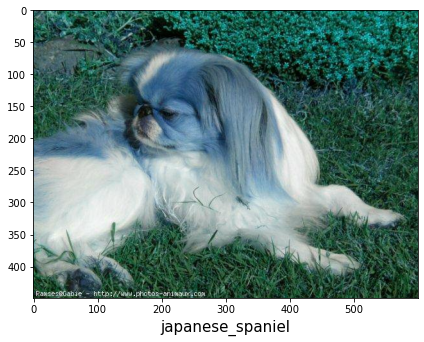

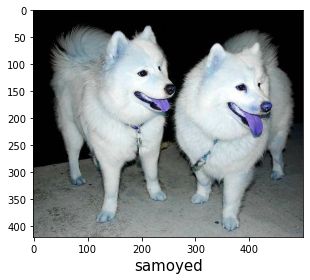

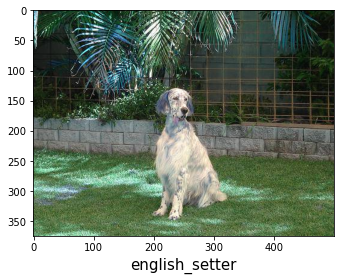

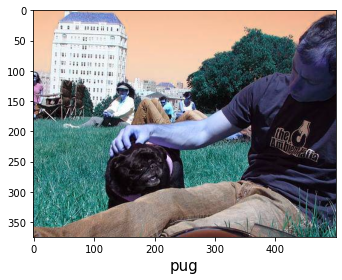

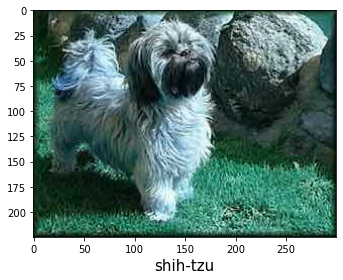

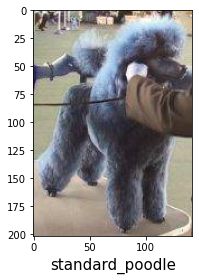

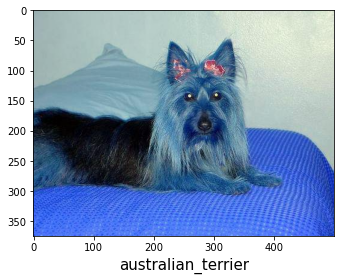

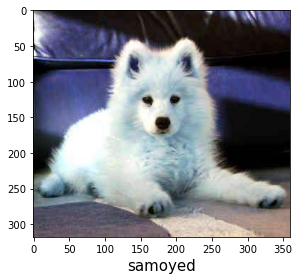

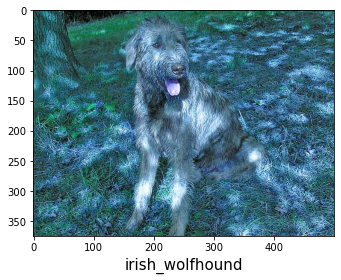

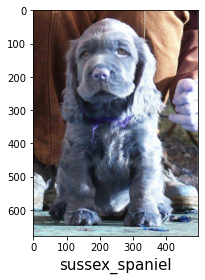

In [61]:
plt.figure(figsize=(6,6))

for index , data in test_dataframe[:10].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
#     plt.subplot(2,5, index+1)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()   

In [62]:
submission=pd.DataFrame(y_pred,columns=classes_to_num.keys())
submission

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,2.044586e-06,2.409271e-06,3.025254e-06,3.494807e-06,1.547178e-06,2.201509e-06,1.328959e-06,2.520507e-06,3.807405e-06,5.128082e-06,...,2.449612e-06,2.968634e-06,3.091908e-06,3.023420e-06,3.436802e-06,3.596973e-06,3.785064e-06,1.395369e-06,3.412255e-06,1.591101e-06
1,9.330973e-08,3.097768e-08,9.388063e-08,3.745641e-08,6.321508e-08,1.892689e-08,2.151060e-08,7.136261e-08,7.418103e-08,3.885576e-08,...,5.284337e-08,4.123130e-08,3.872436e-08,5.986021e-08,4.461663e-08,3.608364e-08,8.350461e-07,5.620097e-08,2.155117e-08,3.046138e-08
2,4.671761e-05,4.600075e-04,3.822258e-04,1.511190e-04,1.012021e-04,1.070683e-04,9.738874e-05,8.117610e-05,1.018855e-04,8.043223e-05,...,5.839005e-05,1.244764e-04,2.392401e-04,1.168375e-04,2.565644e-04,7.705788e-05,1.169887e-04,1.746027e-04,7.484158e-05,4.907074e-05
3,2.221958e-08,3.749679e-11,1.158348e-11,1.021153e-11,1.972712e-10,3.497617e-12,1.771976e-11,3.817591e-09,2.194515e-10,1.148355e-11,...,4.382195e-12,1.020000e-10,1.331851e-10,3.108367e-11,2.857758e-10,3.167958e-11,1.934607e-11,9.765936e-10,3.687643e-13,2.213942e-11
4,9.594269e-03,1.523092e-05,1.824845e-05,8.164419e-06,2.111691e-05,4.979644e-05,2.527783e-05,1.732396e-05,1.076187e-04,2.384304e-05,...,6.111567e-06,2.293464e-05,1.403771e-05,3.053517e-05,2.259671e-05,1.219150e-05,2.389120e-05,1.444720e-05,2.134748e-05,3.400985e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,1.030272e-04,6.695624e-05,1.904181e-04,1.849798e-04,6.773070e-05,9.911689e-05,8.078336e-05,1.769815e-04,9.448387e-05,6.714539e-05,...,3.609692e-04,1.296025e-04,2.071417e-04,3.116257e-04,8.254559e-05,1.480309e-04,7.965983e-05,2.429813e-04,7.907383e-05,9.964802e-05
10353,8.477102e-06,3.741940e-06,2.806227e-06,5.671275e-06,5.606764e-06,1.458856e-06,6.565945e-06,2.889105e-06,3.052965e-06,3.220173e-06,...,7.687865e-07,2.634768e-06,1.410153e-04,3.668620e-06,9.986987e-01,5.440454e-06,6.577991e-06,1.516679e-05,3.356046e-06,9.946168e-06
10354,1.185916e-06,8.530857e-07,8.887242e-05,1.478621e-06,1.019685e-06,4.009578e-07,5.760339e-07,1.433040e-06,7.657655e-06,2.631180e-06,...,7.329413e-07,2.124010e-06,6.127032e-07,2.309103e-06,1.101413e-06,4.259433e-06,1.185791e-06,1.664143e-06,8.298978e-07,6.815801e-07
10355,9.883078e-05,1.273858e-04,3.509044e-05,9.595045e-05,8.497285e-05,5.759770e-05,1.951389e-04,6.821870e-05,8.277608e-05,5.282897e-05,...,4.864997e-04,3.560820e-05,1.150696e-04,7.275943e-05,2.194844e-05,4.859370e-05,5.374228e-05,8.097487e-05,1.464007e-05,1.222443e-04


In [63]:
pd.set_option('display.float_format', lambda x: '%.15f' % x)
submission

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,0.000002044585699,0.000002409271247,0.000003025254045,0.000003494807288,0.000001547177590,0.000002201509005,0.000001328958660,0.000002520506541,0.000003807405164,0.000005128082194,...,0.000002449612339,0.000002968633680,0.000003091908184,0.000003023419822,0.000003436801762,0.000003596972874,0.000003785063882,0.000001395369054,0.000003412255410,0.000001591101409
1,0.000000093309730,0.000000030977684,0.000000093880629,0.000000037456413,0.000000063215083,0.000000018926890,0.000000021510598,0.000000071362614,0.000000074181031,0.000000038855759,...,0.000000052843372,0.000000041231303,0.000000038724359,0.000000059860206,0.000000044616630,0.000000036083645,0.000000835046137,0.000000056200967,0.000000021551172,0.000000030461376
2,0.000046717606892,0.000460007548099,0.000382225844078,0.000151118976646,0.000101202145743,0.000107068284706,0.000097388743598,0.000081176098320,0.000101885532786,0.000080432233517,...,0.000058390050981,0.000124476369820,0.000239240107476,0.000116837516543,0.000256564380834,0.000077057884482,0.000116988710943,0.000174602668267,0.000074841576861,0.000049070742534
3,0.000000022219577,0.000000000037497,0.000000000011583,0.000000000010212,0.000000000197271,0.000000000003498,0.000000000017720,0.000000003817591,0.000000000219452,0.000000000011484,...,0.000000000004382,0.000000000102000,0.000000000133185,0.000000000031084,0.000000000285776,0.000000000031680,0.000000000019346,0.000000000976594,0.000000000000369,0.000000000022139
4,0.009594269096851,0.000015230917597,0.000018248450942,0.000008164419341,0.000021116913558,0.000049796439271,0.000025277831810,0.000017323962311,0.000107618689071,0.000023843040253,...,0.000006111567018,0.000022934635126,0.000014037709661,0.000030535171391,0.000022596708732,0.000012191499081,0.000023891203455,0.000014447197827,0.000021347483198,0.000034009852243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,0.000103027217847,0.000066956235969,0.000190418140846,0.000184979842743,0.000067730703449,0.000099116885394,0.000080783356680,0.000176981469849,0.000094483868452,0.000067145389039,...,0.000360969221219,0.000129602500238,0.000207141725696,0.000311625713948,0.000082545586338,0.000148030885612,0.000079659825133,0.000242981288466,0.000079073826782,0.000099648023024
10353,0.000008477101801,0.000003741940191,0.000002806226803,0.000005671275176,0.000005606763807,0.000001458856104,0.000006565945114,0.000002889105417,0.000003052964757,0.000003220172857,...,0.000000768786549,0.000002634768180,0.000141015261761,0.000003668619911,0.998698711395264,0.000005440453606,0.000006577991371,0.000015166787307,0.000003356045681,0.000009946167665
10354,0.000001185915835,0.000000853085680,0.000088872424385,0.000001478620788,0.000001019684646,0.000000400957759,0.000000576033869,0.000001433039529,0.000007657655260,0.000002631179768,...,0.000000732941317,0.000002124009825,0.000000612703218,0.000002309102683,0.000001101413204,0.000004259432899,0.000001185791348,0.000001664142701,0.000000829897829,0.000000681580104
10355,0.000098830780189,0.000127385763335,0.000035090437450,0.000095950446848,0.000084972853074,0.000057597695559,0.000195138913114,0.000068218701927,0.000082776081399,0.000052828967455,...,0.000486499746330,0.000035608201870,0.000115069626190,0.000072759430623,0.000021948439098,0.000048593701649,0.000053742282034,0.000080974874436,0.000014640067093,0.000122244266095


In [64]:
sample_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
1,00102ee9d8eb90812350685311fe5890,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
4,001a5f3114548acdefa3d4da05474c2e,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10353,fff1ec9e6e413275984966f745a313b0,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10354,fff74b59b758bbbf13a5793182a9bbe4,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333
10355,fff7d50d848e8014ac1e9172dc6762a3,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,...,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333,0.008333333333333


In [65]:
sample_df=sample_df[['id']]
sample_df

,id
0,000621fb3cbb32d8935728e48679680e
1,00102ee9d8eb90812350685311fe5890
2,0012a730dfa437f5f3613fb75efcd4ce
3,001510bc8570bbeee98c8d80c8a95ec1
4,001a5f3114548acdefa3d4da05474c2e
...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8
10353,fff1ec9e6e413275984966f745a313b0
10354,fff74b59b758bbbf13a5793182a9bbe4
10355,fff7d50d848e8014ac1e9172dc6762a3


In [66]:
submission=pd.merge(sample_df,submission,left_index=True,right_index=True)
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000002044585699,0.000002409271247,0.000003025254045,0.000003494807288,0.000001547177590,0.000002201509005,0.000001328958660,0.000002520506541,0.000003807405164,...,0.000002449612339,0.000002968633680,0.000003091908184,0.000003023419822,0.000003436801762,0.000003596972874,0.000003785063882,0.000001395369054,0.000003412255410,0.000001591101409
1,00102ee9d8eb90812350685311fe5890,0.000000093309730,0.000000030977684,0.000000093880629,0.000000037456413,0.000000063215083,0.000000018926890,0.000000021510598,0.000000071362614,0.000000074181031,...,0.000000052843372,0.000000041231303,0.000000038724359,0.000000059860206,0.000000044616630,0.000000036083645,0.000000835046137,0.000000056200967,0.000000021551172,0.000000030461376
2,0012a730dfa437f5f3613fb75efcd4ce,0.000046717606892,0.000460007548099,0.000382225844078,0.000151118976646,0.000101202145743,0.000107068284706,0.000097388743598,0.000081176098320,0.000101885532786,...,0.000058390050981,0.000124476369820,0.000239240107476,0.000116837516543,0.000256564380834,0.000077057884482,0.000116988710943,0.000174602668267,0.000074841576861,0.000049070742534
3,001510bc8570bbeee98c8d80c8a95ec1,0.000000022219577,0.000000000037497,0.000000000011583,0.000000000010212,0.000000000197271,0.000000000003498,0.000000000017720,0.000000003817591,0.000000000219452,...,0.000000000004382,0.000000000102000,0.000000000133185,0.000000000031084,0.000000000285776,0.000000000031680,0.000000000019346,0.000000000976594,0.000000000000369,0.000000000022139
4,001a5f3114548acdefa3d4da05474c2e,0.009594269096851,0.000015230917597,0.000018248450942,0.000008164419341,0.000021116913558,0.000049796439271,0.000025277831810,0.000017323962311,0.000107618689071,...,0.000006111567018,0.000022934635126,0.000014037709661,0.000030535171391,0.000022596708732,0.000012191499081,0.000023891203455,0.000014447197827,0.000021347483198,0.000034009852243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.000103027217847,0.000066956235969,0.000190418140846,0.000184979842743,0.000067730703449,0.000099116885394,0.000080783356680,0.000176981469849,0.000094483868452,...,0.000360969221219,0.000129602500238,0.000207141725696,0.000311625713948,0.000082545586338,0.000148030885612,0.000079659825133,0.000242981288466,0.000079073826782,0.000099648023024
10353,fff1ec9e6e413275984966f745a313b0,0.000008477101801,0.000003741940191,0.000002806226803,0.000005671275176,0.000005606763807,0.000001458856104,0.000006565945114,0.000002889105417,0.000003052964757,...,0.000000768786549,0.000002634768180,0.000141015261761,0.000003668619911,0.998698711395264,0.000005440453606,0.000006577991371,0.000015166787307,0.000003356045681,0.000009946167665
10354,fff74b59b758bbbf13a5793182a9bbe4,0.000001185915835,0.000000853085680,0.000088872424385,0.000001478620788,0.000001019684646,0.000000400957759,0.000000576033869,0.000001433039529,0.000007657655260,...,0.000000732941317,0.000002124009825,0.000000612703218,0.000002309102683,0.000001101413204,0.000004259432899,0.000001185791348,0.000001664142701,0.000000829897829,0.000000681580104
10355,fff7d50d848e8014ac1e9172dc6762a3,0.000098830780189,0.000127385763335,0.000035090437450,0.000095950446848,0.000084972853074,0.000057597695559,0.000195138913114,0.000068218701927,0.000082776081399,...,0.000486499746330,0.000035608201870,0.000115069626190,0.000072759430623,0.000021948439098,0.000048593701649,0.000053742282034,0.000080974874436,0.000014640067093,0.000122244266095


In [67]:
submission.to_csv('dog_breed_classifier2.csv',index=None)

In [68]:
pd.read_csv('dog_breed_classifier2.csv')

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.000002044585700,0.000002409271200,0.000003025254000,0.000003494807300,0.000001547177600,0.000002201509000,0.000001328958700,0.000002520506500,0.000003807405200,...,0.000002449612300,0.000002968633700,0.000003091908200,0.000003023419800,0.000003436801800,0.000003596972900,0.000003785063900,0.000001395369000,0.000003412255400,0.000001591101400
1,00102ee9d8eb90812350685311fe5890,0.000000093309730,0.000000030977684,0.000000093880630,0.000000037456413,0.000000063215080,0.000000018926890,0.000000021510598,0.000000071362614,0.000000074181030,...,0.000000052843372,0.000000041231303,0.000000038724360,0.000000059860206,0.000000044616630,0.000000036083645,0.000000835046140,0.000000056200967,0.000000021551172,0.000000030461376
2,0012a730dfa437f5f3613fb75efcd4ce,0.000046717607000,0.000460007550000,0.000382225840000,0.000151118980000,0.000101202146000,0.000107068285000,0.000097388740000,0.000081176100000,0.000101885530000,...,0.000058390050000,0.000124476370000,0.000239240110000,0.000116837520000,0.000256564380000,0.000077057884000,0.000116988710000,0.000174602670000,0.000074841580000,0.000049070743000
3,001510bc8570bbeee98c8d80c8a95ec1,0.000000022219577,0.000000000037497,0.000000000011583,0.000000000010212,0.000000000197271,0.000000000003498,0.000000000017720,0.000000003817591,0.000000000219452,...,0.000000000004382,0.000000000102000,0.000000000133185,0.000000000031084,0.000000000285776,0.000000000031680,0.000000000019346,0.000000000976594,0.000000000000369,0.000000000022139
4,001a5f3114548acdefa3d4da05474c2e,0.009594269000000,0.000015230918000,0.000018248451000,0.000008164419000,0.000021116914000,0.000049796440000,0.000025277832000,0.000017323962000,0.000107618690000,...,0.000006111567000,0.000022934635000,0.000014037710000,0.000030535170000,0.000022596709000,0.000012191499000,0.000023891203000,0.000014447198000,0.000021347483000,0.000034009852000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,ffeda8623d4eee33c6d1156a2ecbfcf8,0.000103027220000,0.000066956236000,0.000190418140000,0.000184979840000,0.000067730700000,0.000099116885000,0.000080783360000,0.000176981470000,0.000094483870000,...,0.000360969220000,0.000129602500000,0.000207141730000,0.000311625700000,0.000082545586000,0.000148030890000,0.000079659825000,0.000242981290000,0.000079073830000,0.000099648020000
10353,fff1ec9e6e413275984966f745a313b0,0.000008477102000,0.000003741940200,0.000002806226800,0.000005671275000,0.000005606764000,0.000001458856100,0.000006565945000,0.000002889105400,0.000003052964800,...,0.000000768786550,0.000002634768200,0.000141015260000,0.000003668620000,0.998698700000000,0.000005440453600,0.000006577991400,0.000015166787000,0.000003356045700,0.000009946168000
10354,fff74b59b758bbbf13a5793182a9bbe4,0.000001185915800,0.000000853085700,0.000088872424000,0.000001478620800,0.000001019684600,0.000000400957760,0.000000576033870,0.000001433039500,0.000007657655000,...,0.000000732941300,0.000002124009800,0.000000612703200,0.000002309102700,0.000001101413200,0.000004259433000,0.000001185791300,0.000001664142700,0.000000829897830,0.000000681580100
10355,fff7d50d848e8014ac1e9172dc6762a3,0.000098830780000,0.000127385760000,0.000035090437000,0.000095950450000,0.000084972850000,0.000057597696000,0.000195138910000,0.000068218700000,0.000082776080000,...,0.000486499750000,0.000035608202000,0.000115069626000,0.000072759430000,0.000021948440000,0.000048593700000,0.000053742282000,0.000080974874000,0.000014640067000,0.000122244270000
